## Functions and Data

In [1]:
import datetime
import copy
import os


import numpy as np
from numpy.random import normal as rnorm, multinomial as rmultinomial
import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


plt.style.use(['seaborn-talk'])

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=sm.tools.sm_exceptions.DomainWarning)
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
data_W = pd.read_excel(r"data/Hourly Weather and No Outlier Wachapreague Data.xlsx", parse_dates=[r"Date"])
data_W = data_W.drop(
    columns=["Wind Direction (degrees)", "Water Level Anomalies (m)"]
    ).rename(
    columns = {"Date": "time_min", 
                "Wind Speed (m/s)": "wind",
               "Air Pressure (mb)": "airpressure",
               "Precipitation (mm/hr)": "precipitation", 
               "Temperature ©": "temperature",
               "Salinity (ppt)": "salinity",
               "DO (mg/L)": "ODO",
               "Water Level (m)": "waterlevel",
               "Log10(Chl+1) (log10(ug/L))": "log10_chlorophyll",
              }
    ).set_index("time_min")

data_W["chlorophyll"] = data_W["log10_chlorophyll"].map(lambda x: np.power(10, x))
data_W["date"] = data_W.index.date
data_W = data_W.dropna()

# data_W = pd.read_excel(r"data/Corrected W All.xlsx", sheet_name = "Sheet1", parse_dates=[r"Combine"],)
# data_W = data_W.drop(
#     columns=["MM/DD/YY", "HH:mm:SS", "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "Unnamed: 15"]
#     ).rename(
#     columns = {"Combine": "time_min",
#                "Temp ('C)": "temperature",
#                "SpCond (ms/cm)": "conductivity",
#                "Salinity (ppt)": "salinity",
#                "ODO (mg/L)": "ODO",
#                "Turb (NTU)": "turbidity",
#                "Chl (ug/L)": "chlorophyll",
#               }
#     ).set_index("time_min")
# data_W["date"] = data_W.index.date
# data_W["log10_chlorophyll"] = data_W["chlorophyll"].map(np.log10)
# data_W = data_W.dropna()


In [4]:
data_W

,wind,airpressure,precipitation,temperature,salinity,ODO,log10_chlorophyll,waterlevel,chlorophyll,date
time_min,,,,,,,,,,
2016-03-25 20:00:00,1.870000,1012.210000,0.76,16.70975,30.9550,8.0425,0.360495,0.938,2.293480,2016-03-25
2016-03-25 21:00:00,2.500000,1013.730000,0.53,16.43975,31.2575,7.8200,0.319070,1.127,2.084826,2016-03-25
2016-03-25 22:00:00,3.690000,1014.980000,0.20,15.83275,31.4425,7.8650,0.327645,1.268,2.126401,2016-03-25
2016-03-25 23:00:00,4.180000,1015.490000,0.03,15.43950,31.4775,7.8525,0.330899,1.324,2.142390,2016-03-25
2016-03-26 00:00:00,3.150000,1016.750000,0.00,15.45900,31.3925,7.7400,0.325592,1.238,2.116372,2016-03-26
...,...,...,...,...,...,...,...,...,...,...
2022-12-30 09:00:00,1.970000,1027.990000,0.00,3.83875,30.2475,10.8475,0.256034,0.154,1.803160,2022-12-30
2022-12-30 10:00:00,2.600000,1027.950000,0.00,3.88500,31.0050,11.0250,0.216035,0.408,1.644506,2022-12-30
2022-12-30 17:00:00,0.850000,1024.550000,0.00,5.93050,31.7200,11.5850,0.402570,0.694,2.526794,2022-12-30


In [5]:

data_WW = pd.read_excel(r"data/VIMS WQ Data.xlsx", sheet_name = "WW", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )
data_WW_2 = pd.read_excel(r"data/2022-Willis_Wharf ALL Raw (1).xlsx", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )

data_WW = data_WW.drop(
    columns=["Unnamed: 17", "Unnamed: 18", "MM/DD/YY.1", "Flagged or Deleted Data/Notes", "Log10 chl", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)", "Day"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW_2 = data_WW_2.drop(
    columns=["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW = pd.concat([data_WW[data_WW.index.year < 2022], data_WW_2])
data_WW["log10_chlorophyll"] = data_WW["chlorophyll"].map(np.log10)
data_WW = data_WW.dropna()


d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: invalid value encountered in log10
  new_values = map_f(values, mapper)


In [6]:
data_WW

,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll
time_min,,,,,,,,,
2018-10-12 12:53:04,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711
2018-10-12 14:03:38,2018-10-12,24.615,46.755,30.38,7.86,6.37,19.17,6.34,0.802089
2018-10-12 14:17:40,2018-10-12,24.757,46.513,30.20,7.85,6.54,20.72,6.97,0.843233
2018-10-12 14:32:41,2018-10-12,24.898,46.381,30.10,7.85,6.71,21.37,7.67,0.884795
2018-10-12 14:47:41,2018-10-12,24.940,46.315,30.05,7.86,6.81,23.71,7.33,0.865104
...,...,...,...,...,...,...,...,...,...
2022-12-24 05:02:12,2022-12-24,4.105,46.071,29.17,7.84,9.80,17.23,3.00,0.477121
2022-12-24 05:17:12,2022-12-24,3.908,46.023,29.11,7.84,9.79,17.85,3.09,0.489958
2022-12-24 05:32:12,2022-12-24,3.921,46.073,29.15,7.83,9.72,21.78,3.06,0.485721


In [7]:
def matmul_log(A, log_b):
    res = []
    for tmp_line in A:
        if np.any(tmp_line == 0.) :
            if np.all(tmp_line == 0.) :
                res.append(logsumexp(np.log([1 / len(tmp_line) for i in range(len(tmp_line))]) + log_b))
            else:
                res.append(logsumexp(np.log(tmp_line[tmp_line != 0]) + log_b[tmp_line != 0]))
        else:
            res.append(logsumexp(np.log(tmp_line) + log_b))
    return np.array(res)


In [8]:
class MSLR():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None):
        self.n_components = n_components
        self.n_iter = n_iter
        self.covariance_type = covariance_type 
        self.tol = 0.0
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
        
        return
    
    
    def fit_predict(self, X, Y, X_test, is_multiple_sequence = False, forecast_horizon = 1):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        n_seq = len(list_X)
        list_T = [len(i) for i in list_X]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        K = self.n_components
        self.n_features = p
        
        self.transmat_ = np.array([[1. / K for j in range(K)] for i in range(K)])

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
            list_list_log_emission = [[np.copy(list_cur_mat_log_b[index_X][i, :]) for i in range(T)] for index_X, T in enumerate(list_T)]
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(self.transmat_), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(self.transmat_[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(self.transmat_[ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self.transmat_ = self._calc_transmat(list_tmp_array3d_log_epsilon)
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol):
                break
            
            #print("epoch % s, loglik = % s" % (epoch, loglik))
            #print(cur_list_mvn_mean_cov)
            #print(cur_transmat)
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= np.max(tmp)
            tmp = np.exp(tmp)
            tmp /= np.sum(tmp)
            self.list_last_posterior[ii] = tmp
        
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = self.list_last_posterior[ii] @ np.linalg.matrix_power(self.transmat_, forecast_horizon)
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_transmat(self, list_tmp_array3d_log_epsilon):
        K = self.n_components
        cur_transmat = np.zeros((K, K)) 
        for ii in range(K):
            tmp_list_log_prob = []
            for jj in range(K):
                tmp_log_prob = []
                for index_X in range(len(list_tmp_array3d_log_epsilon)):
                    tmp_log_prob.append(logsumexp(list_tmp_array3d_log_epsilon[index_X][:, ii, jj]))
                tmp_list_log_prob.append(logsumexp(tmp_log_prob))
            tmp_list_log_prob = np.array(tmp_list_log_prob)
            tmp_list_log_prob -= np.max(tmp_list_log_prob)
            tmp_prob = np.exp(tmp_list_log_prob)
            tmp_prob /= sum(tmp_prob)
            cur_transmat[ii, :] = tmp_prob
        return cur_transmat
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
# def _test_MSLR():
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     T = 10000
    
#     list_X, list_Y = [], []
#     list_X_test = []
#     for ii in range(5):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, 3))
#         X_test = np.random.normal(loc=1.0, scale=5.0, size=(1, 3))
#         Y, list_h_label = [], []
#         for tt in range(T):
#             if tt == 0:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = init_prob, size = 1))
#             else:
#                 tmp_h_label = np.argmax(np.random.multinomial(n = 1, pvals = transmat[tmp_h_label], size = 1))
#             list_h_label.append(tmp_h_label)
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_X_test.append(X_test)
        
#     mslr = MSLR(n_components=3, covariance_type="full", n_iter=10)
#     pred = mslr.fit_predict(list_X, list_Y, list_X_test, is_multiple_sequence=True)
#     print(pred)
#     print(mslr.transmat_)
#     print(mslr.startprob_)
#     for tmp_lr, tmp_cov in mslr.list_lr_cov:
#         print(tmp_lr.coef_)
#         print(tmp_lr.intercept_)
#         print(tmp_cov)

#     return


# _test_MSLR()


In [9]:
class MSLRX():
    
    def __init__(self, n_components = 2, covariance_type="full", n_iter = 10, reg_method = "OLS", kargs_reg = None, 
                 is_logistic_regression_CV = False, logistic_regression_C = 1e10, is_logistic_regression_standardized = False,
                is_state_coef_indep = False, is_ordinal_logit = False, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.is_logistic_regression_CV = is_logistic_regression_CV
        self.logistic_regression_C = logistic_regression_C
        self.is_state_coef_indep = is_state_coef_indep
        self.is_ordinal_logit = is_ordinal_logit    # only valid when the response is 1-dim so we could sort it
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
        
        self.is_logistic_regression_standardized = is_logistic_regression_standardized
        if is_logistic_regression_standardized:
            self.standardizer = StandardScaler()
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    if self.is_state_coef_indep or self.is_ordinal_logit:
                        if self.is_initialized:
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            tmp_new_exog = [int(i == ii_index) for i in range(K)]
                            tmp_new_exog.extend(tmp_exog)
                            tmp_prob = self.logit_clf.predict_proba(np.array([tmp_new_exog]))[0]
                            if self.is_ordinal_logit:
                                tmp_prob = tmp_prob[self.list_sorted_index_to_original_index]
                            
                        else:
                            tmp_prob = [1 / K for i in range(K)]
                    else:
                        tmp_log_prob = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                        tmp_log_prob -= np.max(tmp_log_prob)
                        tmp_prob = np.exp(tmp_log_prob)
                        tmp_prob /= np.sum(tmp_prob)
                    tmp_trans_mat.append(tmp_prob)
                list_trans_mat.append(tmp_trans_mat)
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        if self.is_ordinal_logit:
            self.list_sorted_index = np.argsort([i[0] for i, j in self.list_mvn_mean_cov])
            self.list_sorted_index_to_original_index = [i for i, j in sorted(list(enumerate(self.list_sorted_index)), key = lambda x: x[1])]
            #print(self.list_mvn_mean_cov)
            #print([i[0] for i, j in self.list_mvn_mean_cov])
            #print(self.list_sorted_index, self.list_sorted_index_to_original_index)
        
        if self.is_state_coef_indep or self.is_ordinal_logit:
            K = self.n_components
            if self.is_ordinal_logit:
                logit_clf = mord.LogisticAT(alpha = 1 / self.logistic_regression_C, verbose = 0, max_iter = 100)
            else:
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            
            for ii in range(K):
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            
                            ii_index = self.list_sorted_index[ii] if self.is_ordinal_logit else ii
                            jj_index = self.list_sorted_index[jj] if self.is_ordinal_logit else jj
                            
                            tmp_exog = [int(i == ii_index) for i in range(K)]
                            tmp_exog.extend(exog[tt])
                            
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(tmp_exog)
                                tmp_y_nan.append(jj_index)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(tmp_exog)
                                tmp_y.append(jj_index)
                                tmp_weight.append(tmp_weight_cell)
            
            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X.extend(tmp_X_nan)
                    tmp_y.extend(tmp_y_nan)
                    tmp_weight.extend([1 / K for i in range(len(tmp_weight_nan))])

            logit_clf.fit(np.array(tmp_X), np.array(tmp_y), np.array(tmp_weight)) 
            self.logit_clf = logit_clf
            
        else:
            K = self.n_components
            self.list_coef_, self.list_intercept_ = [], []
            for ii in range(K):
                if self.is_logistic_regression_CV:
                    logit_clf = LogisticRegressionCV(multi_class = "multinomial", max_iter = 100)
                else:
                    logit_clf = LogisticRegression(C = self.logistic_regression_C, multi_class = "multinomial", max_iter = 100)
                tmp_X, tmp_y, tmp_weight = [], [], []
                tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
                for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                    T = len(array3d_log_epsilon)
                    for tt in range(T):
                        for jj in range(K):
                            tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                            if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                                tmp_X_nan.append(exog[tt])
                                tmp_y_nan.append(jj)
                                tmp_weight_nan.append(tmp_weight_cell)
                            else:
                                tmp_X.append(exog[tt])
                                tmp_y.append(jj)
                                tmp_weight.append(tmp_weight_cell)

                if len(tmp_y_nan) >= 1: 
                    print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                    if len(set(tmp_y)) < K:
                        tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                        tmp_weight = 1

                logit_clf.fit(tmp_X, tmp_y, tmp_weight)

                if self.n_components == 2:
                    tmp_coef = np.array([- logit_clf.coef_.flatten(), logit_clf.coef_.flatten()])
                    tmp_intercept = np.array([- logit_clf.intercept_[0], logit_clf.intercept_[0]])
                else:
                    tmp_coef = logit_clf.coef_[np.argsort(logit_clf.classes_), :]
                    tmp_intercept = logit_clf.intercept_[np.argsort(logit_clf.classes_)]
                self.list_coef_.append(np.transpose(tmp_coef))
                self.list_intercept_.append(tmp_intercept)
                
        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False, exog_additional = None):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
            list_exog_additional = [np.array(i) for i in exog_additional] if exog_additional is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            list_exog_additional = [np.array(exog_additional)] if exog_additional is not None else None
            
        if self.is_logistic_regression_standardized:
            self.standardizer.fit(np.concatenate(list_exog))
            list_exog = [self.standardizer.transform(i, copy=True) for i in list_exog]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = (p_exog, K)) for i in range(K)]
        self.list_intercept_ = [np.zeros(shape = K) for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []
            
        list_transmat_additional = self._est_trans_mat(list_exog_additional) if list_exog_additional is not None else None
        
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            tmp_transmat = list_cur_list_trans_mat[ii][-1]
            if list_transmat_additional is not None:
                for tmp_transmat_additional in list_transmat_additional[ii]:
                    tmp_transmat = tmp_transmat @ tmp_transmat_additional
            self.list_log_pred_posterior.append(matmul_log(np.transpose(tmp_transmat), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
            
        if self.is_logistic_regression_standardized:
            list_exog_test = [self.standardizer.transform(i, copy=True) for i in list_exog_test]
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRX():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRX()")
    
#     np.random.seed(434)
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[0.1, 0.5], [0.8, 0.5], [0.2, 0.6]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.]), np.array([5., 3.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[1.5, 0.1], [0.1, 1.5]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]])
#     init_prob = np.array([1 / 3, 1 / 2, 1 / 6])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(10):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRX(n_components=3, covariance_type="full", n_iter=10, is_logistic_regression_standardized = True)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True,
#                             exog_additional = [exog[:1] for X in list_X],
#                             )
#     print(pred)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRX()


In [10]:
class MSLRXSoluIII():
    
    def __init__(self, n_components = 2, covariance_type="full", reg_method = "OLS", kargs_reg = None, n_iter = 10, tol_loglik = 0.):
        
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.min_iter = 3
        self.tol_loglik = tol_loglik
        self.is_print_loglik = False
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def _est_trans_mat(self, list_exog):
        
        list_list_trans_mat = []
        for exog in list_exog:
            T, K = len(exog), self.n_components
            list_trans_mat = []
            for tmp_exog in exog:
                tmp_trans_mat = []
                for ii in range(K):
                    tmp_prob_1 = tmp_exog @ self.list_coef_[ii] + self.list_intercept_[ii]
                    tmp_prob_1 = max(min(tmp_prob_1, 1 - 1e-5), 1e-5)
                    tmp_prob_0 = 1 - tmp_prob_1
                    tmp_trans_mat.append([tmp_prob_0, tmp_prob_1])
                list_trans_mat.append(np.array(tmp_trans_mat))
            list_list_trans_mat.append(np.array(list_trans_mat))
            
        return list_list_trans_mat
    
    
    def _update_coef(self, list_array3d_log_epsilon, list_exog):
        
        K = self.n_components
        self.list_coef_, self.list_intercept_ = [], []
        for ii in range(K):
            
            tmp_X, tmp_y, tmp_weight = [], [], []
            tmp_X_nan, tmp_y_nan, tmp_weight_nan = [], [], []
            for array3d_log_epsilon, exog in zip(list_array3d_log_epsilon, list_exog):
                T = len(array3d_log_epsilon)
                for tt in range(T):
                    for jj in range(K):
                        tmp_weight_cell = np.exp(array3d_log_epsilon[tt, ii, jj])
                        if np.isnan(tmp_weight_cell) or np.isinf(tmp_weight_cell):
                            tmp_X_nan.append(exog[tt])
                            tmp_y_nan.append(jj)
                            tmp_weight_nan.append(tmp_weight_cell)
                        else:
                            tmp_X.append(exog[tt])
                            tmp_y.append(jj)
                            tmp_weight.append(tmp_weight_cell)

            if len(tmp_y_nan) >= 1: 
                print("Warning: encountering % s nan in weight in ghmm_exog._update_coef" % len(tmp_y_nan))
                if len(set(tmp_y)) < K:
                    tmp_X, tmp_y, tmp_weight = np.array(tmp_X_nan), np.array(tmp_y_nan), np.array(tmp_weight_nan)
                    tmp_weight = 1
            
            tmp_X = sm.add_constant(tmp_X, has_constant='add', prepend=True)
            res_glm = sm.GLM(exog = tmp_X, endog = tmp_y, family=sm.families.Binomial(link = sm.families.links.identity()), freq_weights = tmp_weight).fit()
            
            tmp_intercept = res_glm.params[0]
            tmp_coef = np.array(res_glm.params[1:])
            
            self.list_coef_.append(tmp_coef) 
            self.list_intercept_.append(tmp_intercept)

        return
    
    
    def fit_predict(self, X, Y, exog, X_test, is_multiple_sequence = False, exog_additional = None):
        
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        self.is_fitted = True
        self.is_initialized = False
        
        if is_multiple_sequence:
            list_X, list_Y = [np.array(i) for i in X], [np.array(i) for i in Y]
            list_X_test = [np.array(i) for i in X_test] if X_test is not None else None
            list_exog = [np.array(i) for i in exog]
            list_exog_additional = [np.array(i) for i in exog_additional] if exog_additional is not None else None
        else:
            list_X, list_Y = [np.array(X)], [np.array(Y)]
            list_X_test = [np.array(X_test)] if X_test is not None else None
            list_exog = [np.array(exog)]
            list_exog_additional = [np.array(exog_additional)]
        
        n_seq = len(list_Y)
        list_T = [len(i) for i in list_Y]
        
        p_X, p = len(list_X[0][0]), len(list_Y[0][0])
        p_exog = len(list_exog[0][0])
        K = self.n_components
        self.n_features = p
        
        marginal_X, marginal_Y = np.concatenate(list_X), np.concatenate(list_Y)
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type, random_state=434)
        gmm.fit(marginal_Y)
        
        self.list_coef_ = [np.zeros(shape = p_exog) for i in range(K)]
        self.list_intercept_ = [1 / K for i in range(K)]
        list_cur_list_trans_mat = self._est_trans_mat(list_exog)

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_Y)
                
            list_lr_cov = []
            for ii in range(K):
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_lr = self.reg_method(**self.kargs_reg)
                tmp_lr.fit(marginal_X, marginal_Y, sample_weight = tmp_weight)
                tmp_resid = marginal_Y - tmp_lr.predict(marginal_X)
                if self.covariance_type == "full":
                    tmp_cov_sum = np.zeros(shape = (p, p))
                    for jj in range(len(marginal_X)):
                        tmp_x = tmp_resid[jj, :]
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                elif self.covariance_type == "diag":
                    tmp_cov = np.array([max(np.sum(tmp_weight * (tmp_resid[:, j] ** 2)) / np.sum(tmp_weight), 1e-12) for j in range(p)])
                list_lr_cov.append((tmp_lr, tmp_cov))
            self.list_lr_cov = list_lr_cov
            
            list_cur_mat_log_b = self._calc_emission_mat(list_X, list_Y)
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([Y[0] for Y in list_Y])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(list_cur_list_trans_mat[index_X][tt - 1]), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
        
            self._update_coef(list_tmp_array3d_log_epsilon, list_exog) # update coef and intercept for transmat
            list_cur_list_trans_mat = self._est_trans_mat(list_exog)
            self.list_cur_list_trans_mat = list_cur_list_trans_mat
            
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            self.is_initialized = True
            
            if self.is_print_loglik:
                print("epoch % s, loglik = % s" % (epoch, loglik))
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol_loglik):
                break
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        self.list_log_pred_posterior = []

        list_transmat_additional = self._est_trans_mat(list_exog_additional) if list_exog_additional is not None else None
        
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= logsumexp(tmp)
            self.list_last_posterior[ii] = np.exp(tmp)
            
            tmp_transmat = list_cur_list_trans_mat[ii][-1]
            if list_transmat_additional is not None:
                for tmp_transmat_additional in list_transmat_additional[ii]:
                    tmp_transmat = tmp_transmat @ tmp_transmat_additional
            self.list_log_pred_posterior.append(matmul_log(np.transpose(tmp_transmat), tmp))
            
        if list_X_test is None:
            pred = None
        else:
            pred = []
            for ii in range(n_seq):
                tmp_pred_prob = np.exp(self.list_log_pred_posterior[ii])
                tmp_pred = 0
                for tmp_k in range(K):
                    tmp_pred += list_lr_cov[tmp_k][0].predict([list_X_test[ii]])[0] * tmp_pred_prob[tmp_k]
                pred.append(tmp_pred)

            if not is_multiple_sequence:
                pred = pred[0]
        
        return pred
    
    
    def fit(self, X, Y, exog, is_multiple_sequence = False):
        self.fit_predict(X = X, Y = Y, exog = exog, X_test = None, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, list_X, list_Y):
        
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_lr, tmp_cov) in enumerate(self.list_lr_cov):
            for index_X, (X, Y) in enumerate(zip(list_X, list_Y)):
                tmp_resid = Y - tmp_lr.predict(X)
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(tmp_resid, mean=[0] * p, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(tmp_resid[:, jj], loc = 0, scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
    def online_predict(self, X_test, Y_test, exog_test, is_multiple_sequence = False):
        
        if not self.is_fitted:
            print("Error: Not fitted. MSLRX's online_predict method must be used AFTER fit")
            return
            
        #matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X_test, list_Y_test = [np.array(i) for i in X_test], [np.array(i) for i in Y_test]  
            list_exog_test = [np.array(i) for i in exog_test] 
        else:
            list_X_test, list_Y_test = [np.array(X_test)], [np.array(Y_test)] 
            list_exog_test = [np.array(exog_test)] 

        list_T = [len(i) for i in list_Y_test]
        K = self.n_components
        
        list_cur_mat_log_b = self._calc_emission_mat(list_X_test, list_Y_test)
        list_cur_list_trans_mat = self._est_trans_mat(list_exog_test)

        list_pred = []
        for ii, (cur_mat_log_b, cur_list_trans_mat) in enumerate(zip(list_cur_mat_log_b, list_cur_list_trans_mat)):
            pred = []
            log_last_posterior = self.list_log_pred_posterior[ii]
            for tt in range(list_T[ii]):
                
                log_last_posterior = log_last_posterior + cur_mat_log_b[tt, :]         
                log_last_posterior = matmul_log(np.transpose(cur_list_trans_mat[tt]), log_last_posterior)                    
                log_last_posterior -= logsumexp(log_last_posterior)
                tmp_posterior = np.exp(log_last_posterior)
                
                if tt + 1 < len(list_X_test[ii]):
                    tmp_mean_pred = 0
                    for tmp_k in range(K):
                        tmp_mean_pred += self.list_lr_cov[tmp_k][0].predict([list_X_test[ii][tt + 1]])[0] * tmp_posterior[tmp_k]
                    pred.append(tmp_mean_pred)
                
            self.list_log_pred_posterior[ii] = log_last_posterior
            pred = np.array(pred)
            list_pred.append(pred)
            
        if not is_multiple_sequence:
            list_pred = list_pred[0]
        list_pred = np.array(list_pred)

        res = list_pred
            
        return res
    
    
# def _test_MSLRXSoluIII():
    
#     start_time = datetime.datetime.now()
#     print("start running _test_MSLRXSoluIII()")
    
#     np.random.seed(434)
    
#     list_beta = [np.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]), 
#                  np.array([[-0.5, 0.7], [-0.5, -0.8], [-0.5, -0.2]]),]
#     list_intercept = [np.array([1., 2.]), np.array([8., 2.])]
#     list_cov = [np.array([[1., 0.1], [0.1, 1.]]), np.array([[3., 0.1], [0.1, 3.]])]
#     transmat = np.array([[0.9, 0.1], [ 0.3, 0.7]])
#     init_prob = np.array([1 / 3, 2 / 3])
#     n_components = len(list_beta)
#     K = n_components
#     p_X = len(list_beta[0])
#     p_exog = 5
    
#     list_coef_transmat = [np.random.uniform(size = (p_exog, K), low = -1., high = 1.) for i in range(K)]
#     list_intercept_transmat = [np.random.uniform(size = K) for i in range(K)]
#     for line in list_coef_transmat:
#         line[0, :] = 0
    
#     T_train = 1000
#     T_test = 50
#     T = T_train + T_test
    
#     list_X, list_Y, list_exog = [], [], []
#     for ii in range(100):
        
#         X = np.random.normal(loc=1.0, scale=5.0, size=(T, p_X))
#         exog = np.random.normal(loc=0.0, scale=1.0, size = (T, p_exog))
#         Y, list_h_label = [], []
#         for tt in range(T):
            
#             index = tt
            
#             if index != 0:
#                 trans_mat = []
#                 for ii in range(K):
#                     tmp_log_prob = exog[index - 1] @ list_coef_transmat[ii] + list_intercept_transmat[ii]
#                     tmp_log_prob -= np.max(tmp_log_prob)
#                     tmp_prob = np.exp(tmp_log_prob)
#                     tmp_prob /= np.sum(tmp_prob)
#                     trans_mat.append(tmp_prob)
#                 trans_mat = np.array(trans_mat)
#                 prob_h_tmp = (h_label_prev @ trans_mat)[0]
#             else:
#                 prob_h_tmp = init_prob
            
#             h_label_tmp_vec = np.random.multinomial(n = 1, pvals = prob_h_tmp, size = 1)
#             h_label_tmp = np.argmax(h_label_tmp_vec)
#             tmp_h_label = h_label_tmp
#             h_label_prev = h_label_tmp_vec
            
#             list_h_label.append(tmp_h_label)
            
#             tmp_Y = X[tt, :] @ list_beta[tmp_h_label] + list_intercept[tmp_h_label] + np.random.multivariate_normal(mean = [0, 0], cov = list_cov[tmp_h_label])
#             Y.append(tmp_Y)
            
#         Y = np.array(Y)
        
#         list_X.append(X)
#         list_Y.append(Y)
#         list_exog.append(exog)
        
#     print("data prepared", str(datetime.datetime.now() - start_time))
        
#     mslrx = MSLRXSoluIII(n_components=2, covariance_type="full", n_iter=10)
#     pred = mslrx.fit_predict(X = [X[:T_train] for X in list_X],
#                              Y = [Y[:T_train] for Y in list_Y],
#                              exog = [exog[:T_train] for exog in list_exog],
#                              X_test = [X[T_train, :] for X in list_X], 
#                              is_multiple_sequence=True,
#                             exog_additional=[exog[:1] for X in list_X])
#     print(pred)
#     ol_pred = mslrx.online_predict(X_test = [X[T_train:] for X in list_X],
#                                    Y_test = [Y[T_train:] for Y in list_Y], 
#                                    exog_test = [exog[T_train:] for exog in list_exog],
#                                    is_multiple_sequence = True)
    
#     list_pred = [[] for i in range(len(list_X))]
#     for cc, (tmp_pred, tmp_pred_ol) in enumerate(zip(pred, ol_pred)):
#         list_pred[cc].append(tmp_pred)
#         list_pred[cc].extend(tmp_pred_ol)

#     print("r2 =", r2_score(y_true = np.array([Y[T_train] for Y in list_Y]).flatten(), y_pred=np.array(pred).flatten()))
#     print("r2 =", r2_score(y_true = np.array([Y[T_train:] for Y in list_Y]).flatten(), y_pred=np.array(list_pred).flatten()))
#     print("running time =", str(datetime.datetime.now() - start_time))
    
#     return


# _test_MSLRXSoluIII()


In [11]:
class SMap:
    
    def __init__(self, theta = 0., reg_method = "OLS", kargs_reg = None):
        
        self.theta = theta
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def fit(self, X, y, sample_weight = None):
        self.X, self.y = np.array(X), np.array(y)
        if sample_weight is None:
            self.sample_weight = np.array([1. for i in range(len(self.X))])
        else:
            self.sample_weight = np.array(sample_weight)
        return
    
    
    def predict(self, X):
        
        X_train, y_train = self.X, self.y
        sample_weight_train = self.sample_weight
        theta = self.theta
        reg_method, kargs_reg = self.reg_method, self.kargs_reg
        
        y_pred = []
        for tmp_X_test in X:
            tmp_X_test = np.array(tmp_X_test)
            tmp_d_vec = np.sqrt(np.sum((X_train - tmp_X_test) ** 2, axis = 1))
            tmp_sample_weight = np.exp(- theta * tmp_d_vec / tmp_d_vec.mean())
            tmp_sample_weight *= sample_weight_train
            tmp_reg = reg_method(**kargs_reg)
            tmp_reg.fit(X_train, y_train, sample_weight = tmp_sample_weight)
            tmp_pred = tmp_reg.predict([tmp_X_test])[0]
            y_pred.append(tmp_pred)
            
        y_pred = np.array(y_pred)
        return y_pred
            
        
# def _test_SMap():
    
#     N, p, n_test = 10000, 5, 1000
#     beta = np.random.uniform(size = p)
#     X = np.random.normal(size = (N, p))
#     y = X @ beta + 2 + np.random.normal(size = N)
    
#     reg = SMap(theta = 0.5)
#     reg.fit(X[:-n_test], y[:-n_test])
#     y_pred = reg.predict(X[-n_test:])
#     print("r2 =", r2_score(y_true=y[-n_test:], y_pred = y_pred))
    
#     return
    
    
# _test_SMap()        
        

In [12]:
class SMapCV:
    
    def __init__(self, thetas = (0.0, 0.5, 1.0, 1.5, 2.0, ), reg_method = "OLS", kargs_reg = None):
        
        self.thetas = thetas
        
        if kargs_reg is None:
            kargs_reg = dict()
        self.kargs_reg = kargs_reg
            
        if reg_method in {"OLS", "LR", "LinearRegression", }:
            self.reg_method = LinearRegression
        elif reg_method in {"Ridge", }:
            self.reg_method = Ridge
        elif reg_method in {"RidgeCV", }:
            self.reg_method = RidgeCV
        elif reg_method in {"LinearSVR", "LinearSVM", }:
            self.reg_method = LinearSVR
        else:
            self.reg_method = reg_method
            
        return
    
    
    def fit(self, X, y, sample_weight = None):
        
        X, y = np.array(X), np.array(y)
        self.X, self.y = X, y
        if sample_weight is None:
            sample_weight = np.array([1. for i in range(len(self.X))])
        else:
            sample_weight = np.array(sample_weight)
        self.sample_weight = sample_weight
        
        dict_theta_pred = {i: [] for i in self.thetas}
        y_true = []
        sample_weight_true = []
        
        kf = KFold(n_splits=10, shuffle = True, random_state = 434)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            sample_weight_train, sample_weight_test = sample_weight[train_index], sample_weight[test_index]
            
            y_true.extend(y_test)
            sample_weight_true.extend(sample_weight_test)
            
            for theta in self.thetas:
                tmp_smap = SMap(theta = theta, reg_method = self.reg_method, kargs_reg = self.kargs_reg)
                tmp_smap.fit(X_train, y_train, sample_weight = sample_weight_train)
                y_pred = tmp_smap.predict(X_test)
                dict_theta_pred[theta].extend(y_pred)
                
        list_theta_r2 = []
        for theta in self.thetas:
            tmp_r2 = r2_score(y_true = y_true, y_pred = dict_theta_pred[theta], sample_weight = sample_weight_true)
            list_theta_r2.append((theta, tmp_r2))
        list_theta_r2.sort(key = lambda x: x[1], reverse = True)        
        theta_opt = list_theta_r2[0][0]
        
        self.theta = theta_opt
        
        return
    
    
    def predict(self, X):
        
        X_train, y_train = self.X, self.y
        theta = self.theta
        reg_method, kargs_reg = self.reg_method, self.kargs_reg
        
        y_pred = []
        for tmp_X_test in X:
            tmp_X_test = np.array(tmp_X_test)
            tmp_d_vec = np.sqrt(np.sum((X_train - tmp_X_test) ** 2, axis = 1))
            tmp_sample_weight = np.exp(- theta * tmp_d_vec / tmp_d_vec.mean())
            tmp_reg = reg_method(**kargs_reg)
            tmp_reg.fit(X_train, y_train, sample_weight = tmp_sample_weight)
            tmp_pred = tmp_reg.predict([tmp_X_test])[0]
            y_pred.append(tmp_pred)
            
        y_pred = np.array(y_pred)
        return y_pred
            
        
# def _test_SMapCV():
    
#     N, p, n_test = 1000, 5, 100
#     beta = np.random.uniform(size = p)
#     X = np.random.normal(size = (N, p))
#     y = X @ beta + 2 + np.random.normal(size = N)
    
#     reg = SMapCV()
#     reg.fit(X[:-n_test], y[:-n_test])
#     y_pred = reg.predict(X[-n_test:])
#     print("theta = ", reg.theta)
#     print("r2 =", r2_score(y_true=y[-n_test:], y_pred = y_pred))
    
#     return
    
    
# _test_SMapCV()        
        

## Predictions (WW) - save prediction results - feature importance

In [13]:

# # 1stmax
# data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
# data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
# data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# # 2ndmax
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)

# # 90-quantile
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)


In [18]:
# # Smoothed
# data_WW_smooth = data_WW.copy()
# data_WW_smooth["datetime"] = data_WW_smooth.index
# data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
# data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

# # regularize_coef, max_rate = 20, 4    # Smooth 3
# # regularize_coef, max_rate = 50, 3    # Smooth 5
# # regularize_coef, max_rate = 5, 10    # Smooth 6
# # regularize_coef, max_rate = 5, 30    # Smooth 8
# # regularize_coef, max_rate = 10, 80    # Smooth 10
# regularize_coef, max_rate = 5, 80    # Smooth 11

# data_WW_smooth["log_chlorophyll_p5"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(x + regularize_coef))

# while True:
    
#     data_WW_smooth_diff = data_WW_smooth.diff()
#     data_WW_smooth["chl_rate_regularized"] = data_WW_smooth_diff["log_chlorophyll_p5"] / data_WW_smooth_diff["datetime"].map(lambda x: x.value / (10 ** 9) / (3600 * 24)).fillna(0.)
#     data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.
    
#     data_WW_smooth["chl_rate_regularized"].hist(bins = 50)
#     plt.show()
    
#     data_WW_smooth["chlorophyll"] = data_WW_smooth.apply(lambda x: x["chlorophyll"] if x["chl_rate_regularized"] < max_rate else np.nan, axis = 1)
    
#     if data_WW_smooth.isnull().any().any():
#         data_WW_smooth = data_WW_smooth.dropna()
#     else:
#         break
        
# data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
# data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
# data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
# data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
# data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
# data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
# data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
# data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)


In [14]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "1day", '1day', 3, 1   # smoothtrim2 trimmed
# forward_period, backward_period, n_std, offset_std = "12hour", '12hour', 3, 1   # smoothtrim4 trimmed
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 3, 1   # smoothtrim6 trimmed
# forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 3, 1   # smoothtrim8 trimmed

# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 3, 1   # smoothtrim9 untrimmed
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 2, 1   # smoothtrim10 untrimmed
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 2, 1   # smoothtrim12 untrimmed
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 1.5, 1   # smoothtrim14 untrimmed
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 3, 1   # smoothtrim16 untrimmed

# forward_period, backward_period, n_std, offset_std = "1day", '1day', 2, 1   # smoothtrim1 untrimmed
# forward_period, backward_period, n_std, offset_std = "1day", '1day', 5, 1   # smoothtrim3 untrimmed
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 5, 1   # smoothtrim5 untrimmed
# forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 5, 1   # smoothtrim7 untrimmed
# forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 3, 1   # smoothtrim11 trimmed
# forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 2, 1   # smoothtrim13 trimmed
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 3, 1   # smoothtrim15 trimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
    
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)


In [15]:
data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])


In [16]:
data_WW_byday = data_WW_byday.dropna().resample("1D").max()

In [17]:
data_WW_byday

,date,conductivity,turbidity,temperature,pH,ODO,salinity_max,salinity_min,chlorophyll,log10_chlorophyll,wind
time_min,,,,,,,,,,,
2019-01-17,2019-01-17,41.905,9.27,4.320865,8.138333,11.25,26.27,20.51,15.87,1.200577,2.467619
2019-01-18,2019-01-18,44.612,14.14,4.865563,8.160833,11.20,28.22,20.78,17.65,1.246745,1.048043
2019-01-19,2019-01-19,44.860,19.43,5.466750,8.180625,11.01,28.47,21.08,22.79,1.357744,3.542546
2019-01-20,2019-01-20,45.246,37.77,6.798094,8.143646,10.45,28.87,21.02,23.63,1.373464,4.180476
2019-01-21,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,2022-12-20,49.115,5.79,5.802531,7.942708,9.53,31.56,28.73,2.69,0.429752,1.510417
2022-12-21,2022-12-21,49.668,9.33,5.474958,7.948021,9.63,31.91,29.18,2.88,0.459392,2.171071
2022-12-22,2022-12-22,49.776,50.00,5.977583,7.944375,9.74,32.03,29.50,3.66,0.563481,4.545590


In [18]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(max(5, horizon_forecast + 2), len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [19]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                # tail_max = "smooth"
                # tail_max = "smooth5"
                # tail_max = "smooth6"
                # tail_max = "smooth8"
                # tail_max = "smooth10"
                # tail_max = "smooth11"
                tail_max = "smoothtrim2"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:17.626972
seq 2 finished 0:00:44.776970
seq 3 finished 0:01:28.021424
seq 4 finished 0:02:09.550463
seq 5 finished 0:03:00.610461
seq 6 finished 0:03:33.801500
seq 7 finished 0:04:02.879503
seq 8 finished 0:08:14.094500
seq 9 finished 0:09:14.797500
seq 10 finished 0:12:56.676909
seq 11 finished 0:15:12.029617
seq 12 finished 0:21:26.203056
seq 13 finished 0:33:35.198109
seq 14 finished 0:43:33.109848
seq 15 finished 0:

In [20]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "12hour", '12hour', 3, 1   # smoothtrim4

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [21]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                tail_max = "smoothtrim4"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:21.877000
seq 2 finished 0:00:57.228001
seq 3 finished 0:01:50.295999
seq 4 finished 0:02:43.776000
seq 5 finished 0:03:46.621000
seq 6 finished 0:04:29.839999
seq 7 finished 0:05:10.709000
seq 8 finished 0:10:03.070999
seq 9 finished 0:11:04.450999
seq 10 finished 0:14:44.229000
seq 11 finished 0:16:59.195999
seq 12 finished 0:22:55.286999
seq 13 finished 0:34:41.806999
seq 14 finished 0:44:30.591999
seq 15 finished 0:

In [22]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 3, 1   # smoothtrim6

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [23]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                # tail_max = "smoothtrim4"
                tail_max = "smoothtrim6"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:20.215998
seq 2 finished 0:00:54.339998
seq 3 finished 0:01:42.261999
seq 4 finished 0:02:33.284998
seq 5 finished 0:03:37.130999
seq 6 finished 0:04:20.838997
seq 7 finished 0:05:02.699998
seq 8 finished 0:09:53.390998
seq 9 finished 0:10:53.312997
seq 10 finished 0:14:27.514998
seq 11 finished 0:16:36.073997
seq 12 finished 0:22:16.008999
seq 13 finished 0:33:18.383998
seq 14 finished 0:42:28.696997
seq 15 finished 0:

In [24]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "3hour", '3hour', 3, 1   # smoothtrim8

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [25]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                # tail_max = "smoothtrim4"
                # tail_max = "smoothtrim6"
                tail_max = "smoothtrim8"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:18.496999
seq 2 finished 0:00:50.726999
seq 3 finished 0:01:39.484000
seq 4 finished 0:02:30.341000
seq 5 finished 0:03:32.650000
seq 6 finished 0:04:15.706001
seq 7 finished 0:04:56.664999
seq 8 finished 0:09:45.940999
seq 9 finished 0:10:46.329001
seq 10 finished 0:14:22.028000
seq 11 finished 0:16:33.813000
seq 12 finished 0:22:20.901248
seq 13 finished 0:35:17.664537
seq 14 finished 0:46:42.137004
seq 15 finished 0:

In [26]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 3, 1   # smoothtrim9 untrimmed
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 2, 1   # smoothtrim10 untrimmed
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 2, 1   # smoothtrim12 untrimmed
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 1.5, 1   # smoothtrim14 untrimmed
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 3, 1   # smoothtrim16 untrimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [27]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                # tail_max = "smoothtrim4"
                tail_max = "smoothtrim9"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:23.394225
seq 2 finished 0:01:01.507806
seq 3 finished 0:01:51.924202
seq 4 finished 0:02:44.922926
seq 5 finished 0:03:49.761923
seq 6 finished 0:04:34.392427
seq 7 finished 0:05:18.585217
seq 8 finished 0:10:46.264781
seq 9 finished 0:11:50.917454
seq 10 finished 0:15:45.292331
seq 11 finished 0:18:05.675086
seq 12 finished 0:24:12.084694
seq 13 finished 0:36:06.172164
seq 14 finished 0:46:16.739966
seq 15 finished 0:

In [28]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 2, 1   # smoothtrim10 untrimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [29]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                # tail_max = "smoothtrim4"
                tail_max = "smoothtrim10"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:22.699813
seq 2 finished 0:01:02.996911
seq 3 finished 0:01:57.248375
seq 4 finished 0:02:49.812377
seq 5 finished 0:03:54.813292
seq 6 finished 0:04:40.756165
seq 7 finished 0:05:23.654962
seq 8 finished 0:10:31.142572
seq 9 finished 0:11:36.131417
seq 10 finished 0:15:31.655868
seq 11 finished 0:17:54.030559
seq 12 finished 0:24:03.882415
seq 13 finished 0:36:17.477381
seq 14 finished 0:46:43.883525
seq 15 finished 0:

In [30]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 2, 1   # smoothtrim12 untrimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [31]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                # tail_max = "smoothtrim4"
                tail_max = "smoothtrim12"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:18.938711
seq 2 finished 0:00:52.113518
seq 3 finished 0:01:43.226163
seq 4 finished 0:02:33.767375
seq 5 finished 0:03:37.988597
seq 6 finished 0:04:21.835862
seq 7 finished 0:05:03.004176
seq 8 finished 0:10:01.916467
seq 9 finished 0:11:03.531596
seq 10 finished 0:14:49.434198
seq 11 finished 0:17:04.904996
seq 12 finished 0:23:04.324575
seq 13 finished 0:35:27.876128
seq 14 finished 0:46:11.831340
seq 15 finished 0:

In [32]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 1.5, 1   # smoothtrim14 untrimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 430


In [33]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                # tail_max = "smoothtrim4"
                tail_max = "smoothtrim14"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:19.126931
seq 2 finished 0:00:54.405376
seq 3 finished 0:01:45.532496
seq 4 finished 0:02:35.926906
seq 5 finished 0:03:40.462857
seq 6 finished 0:04:25.342495
seq 7 finished 0:05:06.919327
seq 8 finished 0:10:12.883658
seq 9 finished 0:11:14.058778
seq 10 finished 0:14:54.854992
seq 11 finished 0:17:09.857264
seq 12 finished 0:23:10.188419
seq 13 finished 0:35:36.499746
seq 14 finished 0:46:22.542259
seq 15 finished 0:

In [34]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 3, 1   # smoothtrim16 untrimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [35]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                # tail_max = "smoothtrim4"
                tail_max = "smoothtrim16"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:18.526605
seq 2 finished 0:00:48.318444
seq 3 finished 0:01:28.324666
seq 4 finished 0:02:10.552020
seq 5 finished 0:03:02.562680
seq 6 finished 0:03:41.731957
seq 7 finished 0:04:18.811219
seq 8 finished 0:08:24.401641
seq 9 finished 0:09:13.416383
seq 10 finished 0:12:16.132642
seq 11 finished 0:14:11.385565
seq 12 finished 0:19:56.018393
seq 13 finished 0:32:00.026129
seq 14 finished 0:42:00.270729
seq 15 finished 0:

In [36]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 5, 1   # smoothtrim18 untrimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    # tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    # tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    tmp_trimmed_mean = np.mean(tmp_neighbors)
    tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)
    
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


In [37]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                #tail_max = "smooth"
                # tail_max = "smooth4"
                # tail_max = "smooth7"
                # tail_max = "smooth9"
                # tail_max = "smoothtrim2"
                # tail_max = "smoothtrim4"
                tail_max = "smoothtrim18"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:22.645000
seq 2 finished 0:01:00.459001
seq 3 finished 0:01:53.178497
seq 4 finished 0:02:48.866383
seq 5 finished 0:03:56.413545
seq 6 finished 0:04:40.314627
seq 7 finished 0:05:22.065628
seq 8 finished 0:10:14.090928
seq 9 finished 0:11:15.579344
seq 10 finished 0:14:57.558227
seq 11 finished 0:16:51.571045
seq 12 finished 0:21:41.175771
seq 13 finished 0:34:24.885836
seq 14 finished 0:45:02.946502
seq 15 finished 0:

In [38]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "2hour", '2hour', 1, 1, 1, False   # smoothmeanstd1

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 40


In [39]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd1"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:20.178995
seq 2 finished 0:00:54.377996
seq 3 finished 0:01:42.014995
seq 4 finished 0:02:32.203995
seq 5 finished 0:03:35.742996
seq 6 finished 0:04:18.558995
seq 7 finished 0:04:59.650995
seq 8 finished 0:09:48.279995
seq 9 finished 0:10:48.009995
seq 10 finished 0:14:25.233041
seq 11 finished 0:16:37.029999
seq 12 finished 0:22:02.245292
seq 13 finished 0:35:07.023853
seq 14 finished 0:45:42.510255
seq 15 finished 0:

In [40]:
# Smoothed (trimmed mean var)


forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "3hour", '3hour', 1, 1, 1, False   # smoothmeanstd3

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 65


In [41]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd3"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:21.302700
seq 2 finished 0:00:56.721183
seq 3 finished 0:01:45.719876
seq 4 finished 0:02:37.753142
seq 5 finished 0:03:43.741910
seq 6 finished 0:04:27.472777
seq 7 finished 0:05:09.001563
seq 8 finished 0:09:56.934002
seq 9 finished 0:10:57.112689
seq 10 finished 0:14:32.053795
seq 11 finished 0:16:42.392754
seq 12 finished 0:21:21.545261
seq 13 finished 0:33:29.719683
seq 14 finished 0:44:23.579333
seq 15 finished 0:

In [46]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "1hour", '1hour', 1, 1, 1, False   # smoothmeanstd5

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 19


In [47]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd5"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:18.702454
seq 2 finished 0:00:50.854274
seq 3 finished 0:01:42.202269
seq 4 finished 0:02:36.466867
seq 5 finished 0:03:45.483821
seq 6 finished 0:04:33.140527
seq 7 finished 0:05:17.574796
seq 8 finished 0:10:28.815591
seq 9 finished 0:11:33.994100
seq 10 finished 0:15:31.563589
seq 11 finished 0:17:52.809361
seq 12 finished 0:24:02.517120
seq 13 finished 0:36:23.383327
seq 14 finished 0:46:32.785050
seq 15 finished 0:

In [48]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "24hour", '24hour', 3, 3, 5, False   # smoothmeanstd7

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 10


In [49]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd7"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:17.104999
seq 2 finished 0:00:51.912998
seq 3 finished 0:01:40.028999
seq 4 finished 0:02:32.218998
seq 5 finished 0:03:37.094000
seq 6 finished 0:04:20.322998
seq 7 finished 0:05:02.854998
seq 8 finished 0:09:59.784998
seq 9 finished 0:11:01.620998
seq 10 finished 0:14:40.171999
seq 11 finished 0:16:55.580999
seq 12 finished 0:22:53.026997
seq 13 finished 0:34:43.684999
seq 14 finished 0:44:36.857998
seq 15 finished 0:

In [50]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "6hour", '6hour', 3, 3, 5, False   # smoothmeanstd9

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 8


In [51]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd9"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:16.760001
seq 2 finished 0:00:44.440002
seq 3 finished 0:01:22.609999
seq 4 finished 0:02:13.268000
seq 5 finished 0:03:18.054000
seq 6 finished 0:04:03.146000
seq 7 finished 0:04:45.666000
seq 8 finished 0:09:39.737000
seq 9 finished 0:10:41.119000
seq 10 finished 0:14:21.343000
seq 11 finished 0:16:34.669002
seq 12 finished 0:22:31.289000
seq 13 finished 0:34:17.174001
seq 14 finished 0:44:12.521000
seq 15 finished 0:

In [52]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "1hour", '1hour', 2, 1, 1, False   # smoothmeanstd11

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 7


In [53]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd11"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:16.718999
seq 2 finished 0:00:44.218999
seq 3 finished 0:01:22.248002
seq 4 finished 0:02:01.650000
seq 5 finished 0:02:53.180000
seq 6 finished 0:03:36.613999
seq 7 finished 0:04:18.572999
seq 8 finished 0:09:14.882999
seq 9 finished 0:10:15.971999
seq 10 finished 0:13:55.083999
seq 11 finished 0:16:08.427000
seq 12 finished 0:22:05.146999
seq 13 finished 0:33:55.565999
seq 14 finished 0:43:49.774999
seq 15 finished 0:

In [54]:
# Smoothed (trimmed mean var)

forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "12hour", '0hour', 3, 3, 1, True   # smoothmeanstd13

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

n_invalid = len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"])
print("n_invalid =", n_invalid)

data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]
        
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_byday["chlorophyll"].map(np.log10)

data_W_byday = data_W[["date"]].resample("1D").max()
#data_W_byday["airpressure"] = data_W["airpressure"].resample("1D").mean()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).rename(columns = {"date_x": "date"}).drop(columns = ["date_y"])

data_WW_byday = data_WW_byday.dropna().resample("1D").max()


n_invalid = 42


In [56]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                tail_max = "smoothmeanstd13"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon_smooth", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:21.124371
seq 2 finished 0:00:55.585023
seq 3 finished 0:01:45.408754
seq 4 finished 0:02:36.997025
seq 5 finished 0:03:41.299783
seq 6 finished 0:04:26.556133
seq 7 finished 0:05:08.593340
seq 8 finished 0:10:18.299816
seq 9 finished 0:11:23.201331
seq 10 finished 0:15:17.098967
seq 11 finished 0:17:34.616965
seq 12 finished 0:23:32.130965
seq 13 finished 0:35:17.922965
seq 14 finished 0:45:09.560966
seq 15 finished 0:

In [61]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [31]:

is_log = True
is_phase = True

dict_setting_results = dict()

#for is_cross in [True, False]:
for is_cross in [True, ]:
    for horizon_forecast in [1, 3, 7]:
        for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_featureimportance", fname_write), index = False)



setting = (True, True, True, 1, 'LinearRegression')
removed feature = salinity_max
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:26.193572


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:01:05.852962
seq 3 finished 0:02:09.516619
seq 4 finished 0:03:06.915962
seq 5 finished 0:04:18.696142
seq 6 finished 0:05:05.665142
seq 7 finished 0:05:51.421656
seq 8 finished 0:11:24.710842
seq 9 finished 0:12:35.373918
seq 10 finished 0:16:45.087578
seq 11 finished 0:19:30.712618
seq 12 finished 0:26:20.439541
seq 13 finished 0:40:01.400113
seq 14 finished 0:51:10.653921
seq 15 finished 0:57:06.622342

setting = (True, True, True, 1, 'LinearRegression')
removed feature = salinity_min
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 fin

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:00:59.012217
seq 3 finished 0:01:52.907533
seq 4 finished 0:02:46.965968
seq 5 finished 0:03:53.226128
seq 6 finished 0:04:39.216958
seq 7 finished 0:05:23.644209
seq 8 finished 0:10:37.188194
seq 9 finished 0:11:42.862217
seq 10 finished 0:15:37.375364
seq 11 finished 0:18:22.470026
seq 12 finished 0:25:10.558824
seq 13 finished 0:39:10.743180
seq 14 finished 0:51:11.197649
seq 15 finished 0:57:48.115771

setting = (True, True, True, 1, 'LinearRegression')
removed feature = ODO
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:23.100277


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:01:14.913534
seq 3 finished 0:02:45.932984
seq 4 finished 0:03:49.032783
seq 5 finished 0:05:10.196864
seq 6 finished 0:06:01.822790
seq 7 finished 0:06:52.772981


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \


seq 8 finished 0:12:53.988953
seq 9 finished 0:14:01.752967
seq 10 finished 0:18:05.155919
seq 11 finished 0:20:51.874904
seq 12 finished 0:27:28.374601
seq 13 finished 0:40:40.454602
seq 14 finished 0:51:56.582619
seq 15 finished 0:57:56.672507

setting = (True, True, True, 1, 'LinearRegression')
removed feature = turbidity
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:24.428424


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:01:02.726153
seq 3 finished 0:02:03.304624
seq 4 finished 0:02:56.038998
seq 5 finished 0:04:02.650284
seq 6 finished 0:04:48.087785
seq 7 finished 0:05:31.502377
seq 8 finished 0:10:47.694589
seq 9 finished 0:11:53.643588
seq 10 finished 0:15:48.253587
seq 11 finished 0:18:25.705588
seq 12 finished 0:24:47.480588
seq 13 finished 0:37:35.053588
seq 14 finished 0:48:33.407587
seq 15 finished 0:54:26.562588

setting = (True, True, True, 1, 'LinearRegression')
removed feature = pH
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:21.175001
seq 2 finished 0:00:59.179001
seq 3 finished 0:01:49.816001
seq 4 finished 0:02:44.905000
seq 5 finished 0:03:50.831001
seq 6 finished 0:04:36.437000
seq 7 finished 0:05:20.109000
seq 8 finished 0:10:33.595001
seq 9 finished 0:11:38.677000
seq 10 finished 0:15:32.548000
seq 11 finished 0:18:06.494002
seq 12 finished 0:24:27.291001
seq 13 finished 0:37:27.672002
seq 14 finished 0:48:56.803001
seq 15 finished 0:55:06.271001

setting = (True, True, True, 1, 'LinearRegression')
removed feature = temperature
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-1

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:25.081000


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:01:05.112000
seq 3 finished 0:02:09.340999
seq 4 finished 0:03:01.949000
seq 5 finished 0:04:09.657001
seq 6 finished 0:04:56.251000
seq 7 finished 0:05:40.568002


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \


seq 8 finished 0:11:04.169000
seq 9 finished 0:12:10.868001
seq 10 finished 0:16:08.680000
seq 11 finished 0:18:41.490001
seq 12 finished 0:25:07.106000
seq 13 finished 0:38:03.481000
seq 14 finished 0:49:12.212999
seq 15 finished 0:55:13.379001

setting = (True, True, True, 1, 'LinearRegression')
removed feature = wind
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:24.445000


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:01:00.183999
seq 3 finished 0:01:55.509000
seq 4 finished 0:02:48.194000
seq 5 finished 0:03:54.111000
seq 6 finished 0:04:39.820000
seq 7 finished 0:05:23.819000
seq 8 finished 0:10:36.825000
seq 9 finished 0:11:42.303000
seq 10 finished 0:15:37.050001
seq 11 finished 0:18:11.912000
seq 12 finished 0:24:33.276000
seq 13 finished 0:37:21.622999
seq 14 finished 0:48:23.773000
seq 15 finished 0:54:20.994999

setting = (True, True, True, 3, 'LinearRegression')
removed feature = salinity_max
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:23.675001
seq 2 finished 0:00:52.394001
seq 3 finished 0:01:36.942001
seq 4 finished 0:02:23.887001
seq 5 finished 0:03:25.111001
seq 6 finished 0:04:03.193003
seq 7 finished 0:04:39.655001
seq 8 finished 0:10:02.724000
seq 9 finished 0:10:57.726001
seq 10 finished 0:14:45.132000
seq 11 finished 0:17:09.088001
seq 12 finished 0:23:43.064001
seq 13 finished 0:36:37.023001
seq 14 finished 0:47:22.164001
seq 15 finished 0:52:50.067999

setting = (True, True, True, 3, 'LinearRegression')
removed feature = salinity_min
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:26.282000
seq 2 finished 0:00:58.906000
seq 3 finished 0:01:48.234000
seq 4 finished 0:02:38.272000
seq 5 finished 0:03:37.652999
seq 6 finished 0:04:15.918000
seq 7 finished 0:04:52.825999
seq 8 finished 0:10:13.138000
seq 9 finished 0:11:08.130000
seq 10 finished 0:14:54.900000
seq 11 finished 0:17:12.113999
seq 12 finished 0:23:16.334000
seq 13 finished 0:35:42.434000
seq 14 finished 0:46:17.365999
seq 15 finished 0:51:38.176998

setting = (True, True, True, 3, 'LinearRegression')
removed feature = ODO
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 202

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:18.986999


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:00:57.986999
seq 3 finished 0:01:53.083000
seq 4 finished 0:02:41.879000
seq 5 finished 0:03:40.369000
seq 6 finished 0:04:19.185001
seq 7 finished 0:04:56.895000
seq 8 finished 0:10:09.820000
seq 9 finished 0:11:04.180000
seq 10 finished 0:14:47.758999
seq 11 finished 0:17:04.961000
seq 12 finished 0:23:24.021000
seq 13 finished 0:35:59.242000
seq 14 finished 0:46:42.828999
seq 15 finished 0:52:09.231001

setting = (True, True, True, 3, 'LinearRegression')
removed feature = turbidity
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:19.465000


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:00:56.144001
seq 3 finished 0:01:50.697001
seq 4 finished 0:02:40.395000
seq 5 finished 0:03:40.009001
seq 6 finished 0:04:18.500002
seq 7 finished 0:04:56.041001
seq 8 finished 0:10:40.344001
seq 9 finished 0:11:38.611001
seq 10 finished 0:15:34.387001
seq 11 finished 0:17:58.083001
seq 12 finished 0:24:32.694001
seq 13 finished 0:37:36.161513
seq 14 finished 0:48:31.494512
seq 15 finished 0:54:02.913513

setting = (True, True, True, 3, 'LinearRegression')
removed feature = pH
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:25.324999


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:01:07.018000
seq 3 finished 0:02:04.352999
seq 4 finished 0:02:52.214999
seq 5 finished 0:03:50.959999
seq 6 finished 0:04:31.582999
seq 7 finished 0:05:10.829999
seq 8 finished 0:10:12.931999
seq 9 finished 0:11:07.952999
seq 10 finished 0:14:53.510999
seq 11 finished 0:17:09.936999
seq 12 finished 0:23:27.684000
seq 13 finished 0:35:52.599998
seq 14 finished 0:46:27.320999
seq 15 finished 0:51:51.922998

setting = (True, True, True, 3, 'LinearRegression')
removed feature = temperature
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:23.918001


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 2 finished 0:01:04.524001
seq 3 finished 0:02:01.089002
seq 4 finished 0:02:51.103001
seq 5 finished 0:03:48.682001
seq 6 finished 0:04:26.910000
seq 7 finished 0:05:05.255000
seq 8 finished 0:10:12.076001
seq 9 finished 0:11:07.208000
seq 10 finished 0:14:52.334001
seq 11 finished 0:17:11.850001
seq 12 finished 0:23:21.403001
seq 13 finished 0:35:52.996000
seq 14 finished 0:46:41.885001
seq 15 finished 0:52:27.859001

setting = (True, True, True, 3, 'LinearRegression')
removed feature = wind
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:22.599000
seq 2 finished 0:01:00.505000
seq 3 finished 0:01:52.195000
seq 4 finished 0:02:43.715000
seq 5 finished 0:03:43.505000
seq 6 finished 0:04:22.946001
seq 7 finished 0:05:01.299000
seq 8 finished 0:10:46.011000
seq 9 finished 0:11:43.732999
seq 10 finished 0:15:38.711000
seq 11 finished 0:18:00.216000
seq 12 finished 0:24:26.987999
seq 13 finished 0:37:04.697002
seq 14 finished 0:47:44.712999
seq 15 finished 0:53:12.921000

setting = (True, True, True, 7, 'LinearRegression')
removed feature = salinity_max
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:16.649001
seq 2 finished 0:00:44.941000
seq 3 finished 0:01:23.992001
seq 4 finished 0:02:04.152000
seq 5 finished 0:02:51.799000
seq 6 finished 0:03:16.528000
seq 7 finished 0:03:38.378001
seq 8 finished 0:08:45.073000
seq 9 finished 0:09:25.123000
seq 10 finished 0:12:50.238001
seq 11 finished 0:14:39.193999
seq 12 finished 0:20:22.038000
seq 13 finished 0:31:46.583000
seq 14 finished 0:41:36.036000
seq 15 finished 0:46:13.334000

setting = (True, True, True, 7, 'LinearRegression')
removed feature = salinity_min
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:16.738000
seq 2 finished 0:00:45.952998
seq 3 finished 0:01:24.016000
seq 4 finished 0:02:03.917999
seq 5 finished 0:02:52.839000
seq 6 finished 0:03:18.015000
seq 7 finished 0:03:40.336000
seq 8 finished 0:08:33.133000
seq 9 finished 0:09:11.585000
seq 10 finished 0:12:34.886000
seq 11 finished 0:14:23.358001
seq 12 finished 0:19:58.291999
seq 13 finished 0:31:31.263082
seq 14 finished 0:41:38.227581
seq 15 finished 0:46:26.431688

setting = (True, True, True, 7, 'LinearRegression')
removed feature = ODO
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 202

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:18.463712
seq 2 finished 0:00:45.465417
seq 3 finished 0:01:27.802644
seq 4 finished 0:02:09.185411
seq 5 finished 0:02:59.306601
seq 6 finished 0:03:23.999606
seq 7 finished 0:03:45.781806


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 8 finished 0:08:55.201101
seq 9 finished 0:09:36.138983
seq 10 finished 0:13:08.337873
seq 11 finished 0:15:01.656124
seq 12 finished 0:21:01.155196
seq 13 finished 0:32:54.311865
seq 14 finished 0:43:04.873083
seq 15 finished 0:47:59.490774

setting = (True, True, True, 7, 'LinearRegression')
removed feature = pH
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:20.740794
seq 2 finished 0:00:49.901690
seq 3 finished 0:01:37.734980
seq 4 finished 0:02:13.642563
seq 5 finished 0:02:58.940764
seq 6 finished 0:03:23.259929
seq 7 finished 0:03:45.124641
seq 8 finished 0:08:18.008808
seq 9 finished 0:08:56.630595
seq 10 finished 0:12:17.024295
seq 11 finished 0:14:05.449612
seq 12 finished 0:19:50.222885
seq 13 finished 0:31:12.451011
seq 14 finished 0:40:58.148924
seq 15 finished 0:45:43.121851

setting = (True, True, True, 7, 'LinearRegression')
removed feature = temperature
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-1

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:18.756283
seq 2 finished 0:00:48.334552
seq 3 finished 0:01:38.147220
seq 4 finished 0:02:16.846535
seq 5 finished 0:03:05.860892
seq 6 finished 0:03:32.143135
seq 7 finished 0:03:54.487815
seq 8 finished 0:09:11.779385
seq 9 finished 0:09:51.920138
seq 10 finished 0:13:29.681340
seq 11 finished 0:15:23.062123
seq 12 finished 0:21:22.400815
seq 13 finished 0:33:27.338152
seq 14 finished 0:44:00.693987
seq 15 finished 0:48:58.789302

setting = (True, True, True, 7, 'LinearRegression')
removed feature = wind
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 20

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\466811895.py:282: RuntimeWarning: divide by zero enc

seq 1 finished 0:00:17.193543
seq 2 finished 0:00:41.675999
seq 3 finished 0:01:20.328519
seq 4 finished 0:02:00.761553
seq 5 finished 0:02:47.354569
seq 6 finished 0:03:12.677568
seq 7 finished 0:03:34.783618
seq 8 finished 0:08:48.955407
seq 9 finished 0:09:29.794525
seq 10 finished 0:13:05.848942
seq 11 finished 0:15:01.370648
seq 12 finished 0:21:01.410551
seq 13 finished 0:32:36.471552
seq 14 finished 0:42:27.631552
seq 15 finished 0:47:08.560550


In [ ]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(max(5, horizon_forecast + 2), len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                # tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-min(3,horizon_forecast)+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast == 1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                # tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=None)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                # tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=None)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                # tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=min(3, horizon_forecast))
                # tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=1)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [ ]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [True, False]:
    for horizon_forecast in [1, 3, 7]:
        #for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                if is_cross:
                    tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                else:
                    tail_removed_features = "noX"
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                #tail_max = "90qmax"
                tail_max = "smooth"
                
                fname_write = "vimsWW_% s_pred_truehorizon3step_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon1step", fname_write), index = False)


In [82]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [5, 4, 3, 2, 1, ]
    list_p_AR_cross = [3, 2, 1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
    
    print(list_y_true)
    
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [83]:

is_log = True
is_phase = True

dict_setting_results = dict()

#for is_cross in [True, False]:
for is_cross in [True, ]:
    for horizon_forecast in [7]:
        for feature_removed in [None, "salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = False,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_largelag", fname_write), index = False)



setting = (True, True, True, 7, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

seq 1 finished 0:00:00.007014
seq 2 finished 0:00:00.043007
seq 3 finished 0:00:00.149010
seq 4 finished 0:00:00.251847
seq 5 finished 0:00:00.403606
seq 6 finished 0:00:00.434593
seq 7 finished 0:00:00.434593
seq 8 finished 0:00:01.928659
seq 9 finished 0:00:01.961673
seq 10 finished 0:00:03.067308
seq 11 finished 0:00:03.510306
seq 12 finished 0:00:05.399485
seq 13 finished 0:00:10.351993
seq 14 finished 0:00:14.196721
seq 15 finished 0:

TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [131]:
def prslr_feature_selection(X, Y, exog, n_components, covariance_type, n_iter, is_multiple_sequence = False, method = "mslrx"):
    
    S = n_components
    
    if is_multiple_sequence:
        p_X, p_Y = len(X[0][0]), len(Y[0][0])
        X = [np.array(i) for i in X]
        Y = [np.array(i) for i in Y]
    else:
        p_X, p_Y = len(X[0]), len(Y[0])
        X, Y = np.array(X), np.array(Y)
    
    if method.lower() == "mslrx":
        method_cls = MSLRX
    elif method.lower() == "mslrxsolu3":
        method_cls = MSLRXSoluIII
    elif method.lower() == "mslr":
        method_cls = MSLR
    else:
        print("Error: no method = % s" % method)
        return
        
    delta_df = p_Y * S
    
    mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    if method.lower() == "mslr":
        mslrx.fit(X, Y, is_multiple_sequence = is_multiple_sequence)
    else:
        mslrx.fit(X, Y, exog, is_multiple_sequence = is_multiple_sequence)
    
    
    loglik_full = mslrx.list_loglik_[-1]
    
    list_loglik_reduced, list_pvalues = [], []
    for ii in range(p_X):
        list_used_features = [i for i in range(p_X) if i != ii]
        mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
        
        if is_multiple_sequence:
            X_reduced = [i[:, list_used_features] for i in X]
        else:
            X_reduced = X[:, list_used_features]
            
        if method.lower() == "mslr":
            mslrx.fit(X_reduced, Y, is_multiple_sequence = is_multiple_sequence)
        else:
            mslrx.fit(X_reduced, Y, exog, is_multiple_sequence = is_multiple_sequence)
            
        tmp_loglik_reduced = mslrx.list_loglik_[-1]
        list_loglik_reduced.append(tmp_loglik_reduced)
        
        tmp_pvalue = scipy.stats.chi2.sf(-2 * (tmp_loglik_reduced - loglik_full), delta_df)
        list_pvalues.append(tmp_pvalue)
        
    return list_loglik_reduced, list_pvalues, loglik_full
    

In [128]:
def _main(data_byday, horizon_forecast = 1, method_mslr = "mslrx"):
    
    is_cross = True
    is_log = True
    is_phase = True
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    list_loglik_reduced, list_pvalues, loglik_full = prslr_feature_selection(list_X, list_Y, list_exog, is_multiple_sequence = True, 
                                                                             n_components = 2, covariance_type="diag", n_iter = 10, 
                                                                             method = method_mslr)
                
    return list_loglik_reduced, list_pvalues, loglik_full


In [129]:

dict_col_val = dict()

for horizon_forecast in [1, 3, 7]:
    for method_mslr in ["mslrx", "mslrxsolu3", "mslr"]:

        list_loglik_reduced, list_pvalues, loglik_full = _main(data_WW_byday, horizon_forecast = horizon_forecast, method_mslr = method_mslr)

        dict_col_val[(horizon_forecast, method_mslr)] = list_pvalues

tmp_res_df = pd.DataFrame(dict_col_val, index = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind", "AR2", "AR1"])

tmp_res_df.to_csv(r"res/res_vimsww_% s_insample_feature_pvalues.csv" % tail_max)


Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

9
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

9
Subseqs:
	 0 2019-02-05 2019-03-12

In [143]:
def prslr_testing_prs(X, Y, exog, n_components, covariance_type, n_iter, is_multiple_sequence = False, method = "mslrx"):
    
    S = n_components
    
    if method.lower() == "mslrx":
        method_cls = MSLRX
    elif method.lower() == "mslrxsolu3":
        method_cls = MSLRXSoluIII
    else:
        print("Error: no method = % s" % method)
        return
        
    delta_df = 2 * S * (S - 1)
    
    mslrx = method_cls(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    mslrx.fit(X, Y, exog, is_multiple_sequence = is_multiple_sequence)
    loglik_prslr = mslrx.list_loglik_[-1]
    
    mslr = MSLR(n_components = n_components, covariance_type=covariance_type, n_iter = n_iter)
    mslr.fit(X, Y, is_multiple_sequence = is_multiple_sequence)
    loglik_rslr = mslr.list_loglik_[-1]
    
    pvalue = scipy.stats.chi2.sf(-2 * (loglik_rslr - loglik_prslr), delta_df)
    
    return pvalue, loglik_prslr, loglik_rslr
    

In [144]:
def _main(data_byday, horizon_forecast = 1, method_mslr = "mslrx"):
    
    is_cross = True
    is_log = True
    is_phase = True
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    pvalue, loglik_prslr, loglik_rslr = prslr_testing_prs(list_X, list_Y, list_exog, n_components = 2, covariance_type="diag", n_iter = 10, is_multiple_sequence = True, method = method_mslr)
                
    return pvalue, loglik_prslr, loglik_rslr


In [145]:

dict_col_val = dict()

for horizon_forecast in [1, 3, 7]:
    for method_mslr in ["mslrx", "mslrxsolu3", ]:

        pvalue, loglik_prslr, loglik_rslr = _main(data_WW_byday, horizon_forecast = horizon_forecast, method_mslr = method_mslr)

        dict_col_val[(horizon_forecast, method_mslr)] = [pvalue]

tmp_res_df = pd.DataFrame(dict_col_val)

tmp_res_df.to_csv(r"res/res_vimsww_% s_insample_prs_pvalues.csv" % tail_max)


Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46

Subseqs:
	 0 2019-02-05 2019-03-12 37


In [153]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [156]:

is_log = True
is_phase = True

dict_setting_results = dict()

#for is_cross in [True, False]:
for is_cross in [False, ]:
    for horizon_forecast in [1, 3, 7]:
        for feature_removed in [None, ]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                if is_cross:
                    tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                else:
                    tail_removed_features = "noX"
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_nocross", fname_write), index = False)



setting = (True, False, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 1 finished 0:00:26.381857


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 2 finished 0:01:26.225244
seq 3 finished 0:03:00.303547
seq 4 finished 0:03:57.475071
seq 5 finished 0:05:17.597752
seq 6 finished 0:06:11.502606
seq 7 finished 0:07:08.290848


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 8 finished 0:13:42.827171
seq 9 finished 0:14:59.705899
seq 10 finished 0:19:43.724711
seq 11 finished 0:23:47.468994
seq 12 finished 0:31:01.858616
seq 13 finished 0:44:57.796894
seq 14 finished 0:56:22.818631
seq 15 finished 1:02:19.937712

setting = (True, False, True, 3, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 1 finished 0:00:26.140621
seq 2 finished 0:01:14.892129
seq 3 finished 0:02:24.778828
seq 4 finished 0:03:23.411312
seq 5 finished 0:04:23.238286
seq 6 finished 0:05:06.975284
seq 7 finished 0:05:44.981962
seq 8 finished 0:10:50.885292
seq 9 finished 0:11:49.832397
seq 10 finished 0:15:45.050903
seq 11 finished 0:18:14.600710
seq 12 finished 0:24:23.558064
seq 13 finished 0:36:54.926993
seq 14 finished 0:47:37.423206
seq 15 finished 0:53:10.860198

setting = (True, False, True, 7, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2

C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 1 finished 0:00:21.136397


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 2 finished 0:00:55.616206


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 3 finished 0:01:53.475582
seq 4 finished 0:02:43.428707
seq 5 finished 0:03:41.124389
seq 6 finished 0:04:14.499386
seq 7 finished 0:04:41.483762
seq 8 finished 0:09:19.398023
seq 9 finished 0:09:57.476148
seq 10 finished 0:13:19.644826
seq 11 finished 0:15:17.123647
seq 12 finished 0:20:57.796517
seq 13 finished 0:32:38.793119
seq 14 finished 0:43:18.546034
seq 15 finished 0:48:50.281411


In [59]:
def _main(data_byday, 
          is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, 
          n_seq_warmup = 6, is_mslr = True, is_smap_cv = False, list_unused_feature = None,
          #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    list_features = ["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature", "wind"]
    if list_unused_feature is not None:
        for tmp_feature in list_unused_feature:
            list_features.remove(tmp_feature)
            
    if is_log:
        array_obs = data_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_byday["chlorophyll"].to_numpy()

    array_datetime = data_byday["date"].to_numpy()
    array_cross = data_byday[list_features].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date = tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_pred_smap, list_y_pred_ar = [], []
    list_y_date = []
    list_y_seq, list_y_seq_index = [], []
    for cc in range(n_seq_warmup, len(list_X)):
        
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_pred_smap, tmp_list_y_pred_ar = [], []
        tmp_list_y_date = []
        tmp_list_y_seq, tmp_list_y_seq_index = [], []
        for tmp_index_test in range(4 + horizon_forecast, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            tmp_list_exog_additional = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
                if horizon_forecast != 1:
                    tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(-horizon_forecast+1):]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:(tmp_index_test-horizon_forecast+1)]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))
            if horizon_forecast != 1:
                tmp_list_exog_additional.append(copy.deepcopy(list_exog[ii][(tmp_index_test-horizon_forecast+1):tmp_index_test]))
            
            tmp_y_true = list_Y[cc][tmp_index_test]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            
            if horizon_forecast ==  1:
                tmp_list_exog_additional = None
            
            if is_mslr:

                mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                              logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrx.append(tmp_y_pred)

                mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True, exog_additional=tmp_list_exog_additional)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

                mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
                tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True, forecast_horizon=horizon_forecast)
                tmp_y_pred = tmp_pred[-1]
                tmp_list_y_pred_mslr.append(tmp_y_pred)
                
            else:
                tmp_list_y_pred_mslrx.append(0.)
                tmp_list_y_pred_mslrxsolu3.append(0.)
                tmp_list_y_pred_mslr.append(0.)
            
            lr = reg_method_func(**kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_ar.append(tmp_y_pred)
            
            if is_smap_cv:
                lr = SMapCV(thetas = (0.5, 1.0, 1.5, ), reg_method = reg_method, kargs_reg = kargs_reg)
            else:
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
            lr.fit(np.concatenate(tmp_list_X), np.concatenate(tmp_list_Y).flatten())
            tmp_pred = lr.predict(tmp_list_X_test)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_smap.append(tmp_y_pred)

            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])
            tmp_list_y_seq.append(cc)
            tmp_list_y_seq_index.append(tmp_index_test - horizon_forecast + 1)
        
        list_y_date.append(tmp_list_y_date)
        list_y_seq.append(tmp_list_y_seq)
        list_y_seq_index.append(tmp_list_y_seq_index)
        if is_log:
            list_y_true.append(np.power(10, tmp_list_y_true))
            list_y_pred_naive.append(np.power(10, tmp_list_y_pred_naive))
            list_y_pred_mslrx.append(np.power(10, tmp_list_y_pred_mslrx))
            list_y_pred_mslr.append(np.power(10, tmp_list_y_pred_mslr))
            list_y_pred_mslrxsolu3.append(np.power(10, tmp_list_y_pred_mslrxsolu3))
            list_y_pred_ar.append(np.power(10, tmp_list_y_pred_ar))
            list_y_pred_smap.append(np.power(10, tmp_list_y_pred_smap))
        else:
            list_y_true.append(tmp_list_y_true)
            list_y_pred_naive.append(tmp_list_y_pred_naive)
            list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
            list_y_pred_mslr.append(tmp_list_y_pred_mslr)
            list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
            list_y_pred_ar.append(tmp_list_y_pred_ar)
            list_y_pred_smap.append(tmp_list_y_pred_smap)
        
        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))
        
    list_y_date, list_y_true, list_y_pred_naive = np.concatenate(list_y_date).flatten(), np.concatenate(list_y_true).flatten(), np.concatenate(list_y_pred_naive).flatten()
    list_y_pred_mslrx, list_y_pred_mslr, list_y_pred_mslrxsolu3, list_y_pred_ar, list_y_pred_smap = np.concatenate(list_y_pred_mslrx).flatten(), np.concatenate(list_y_pred_mslr).flatten(), np.concatenate(list_y_pred_mslrxsolu3).flatten(), np.concatenate(list_y_pred_ar).flatten(), np.concatenate(list_y_pred_smap).flatten() 
    list_y_seq, list_y_seq_index = np.concatenate(list_y_seq).flatten(), np.concatenate(list_y_seq_index).flatten()
    
    dict_method_pred = {"date": list_y_date, 
                        "true": list_y_true, 
                        "pred_naive": list_y_pred_naive, 
                        "pred_mslrx": list_y_pred_mslrx,
                        "pred_mslr": list_y_pred_mslr,
                        "pred_mslrxsolu3": list_y_pred_mslrxsolu3, 
                        "pred_ar": list_y_pred_ar,
                        "pred_smap": list_y_pred_smap,
                        "seq": list_y_seq,
                        "seq_index": list_y_seq_index,
                       }
                
    return pd.DataFrame(dict_method_pred)


In [159]:

is_log = True
is_phase = True

dict_setting_results = dict()

for is_cross in [False, True]:
#for is_cross in [False, ]:
    for horizon_forecast in [1]:
        for feature_removed in [None]:
                
                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearRegression", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("removed feature =", feature_removed)
                print("================================================")
                
                tmp_res_df = _main(data_WW_byday, n_seq_warmup=1, 
                                  #reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                  reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                  is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast, is_mslr = True,
                                   list_unused_feature = [feature_removed] if feature_removed is not None else None,
                                  )
                
                dict_setting_results[tmp_setting] = tmp_res_df
                
                tail_log = "_log" if is_log else ""
                tail_cross = "_X" if is_cross else ""
                tail_horizon = "% sD" % horizon_forecast
                tail_method = "LR"
                
                if is_cross:
                    tail_removed_features = "EX" + feature_removed.replace("_", "").lower() if feature_removed is not None else "allX" 
                else:
                    tail_removed_features = "noX" 
                
                #tail_max = "2ndmax"
                #tail_max = "1stmax"
                tail_max = "90qmax"
                
                fname_write = "vimsWW_% s_pred_% s_% s_% s% s% s.csv" % (tail_max, tail_removed_features, tail_method, tail_horizon, tail_cross, tail_log, )
                tmp_res_df.to_csv(os.path.join("res", "vimsWW_pred_truehorizon", fname_write), index = False)



setting = (True, False, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 1 finished 0:00:22.960478


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 2 finished 0:01:05.852834
seq 3 finished 0:02:10.064972
seq 4 finished 0:03:02.903222
seq 5 finished 0:04:13.427008
seq 6 finished 0:05:01.273162
seq 7 finished 0:05:49.013882


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 8 finished 0:11:07.700502
seq 9 finished 0:12:13.637064
seq 10 finished 0:16:26.459025
seq 11 finished 0:19:08.685862
seq 12 finished 0:25:55.747253
seq 13 finished 0:39:25.165747
seq 14 finished 0:50:48.697563
seq 15 finished 0:56:39.567757

setting = (True, True, True, 1, 'LinearRegression')
removed feature = None
Subseqs:
	 0 2019-02-05 2019-03-12 37
	 1 2019-03-27 2019-04-17 23
	 2 2019-04-25 2019-05-21 28
	 3 2019-05-24 2019-06-24 33
	 4 2019-06-27 2019-07-25 30
	 5 2019-08-02 2019-09-02 33
	 6 2019-09-06 2019-09-27 23
	 7 2020-04-15 2020-05-04 21
	 8 2021-04-01 2021-06-28 90
	 9 2021-07-01 2021-07-21 22
	 10 2021-09-03 2021-10-27 56
	 11 2021-10-30 2021-12-01 34
	 12 2022-01-15 2022-03-26 72
	 13 2022-03-29 2022-07-23 118
	 14 2022-07-28 2022-10-23 89
	 15 2022-10-26 2022-12-09 46



C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 1 finished 0:00:25.908629


C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:271: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_9484\4042157731.py:284: RuntimeWarning: divide by zero

seq 2 finished 0:01:08.455090
seq 3 finished 0:02:05.574121
seq 4 finished 0:03:03.865181
seq 5 finished 0:04:12.154276
seq 6 finished 0:04:58.574277
seq 7 finished 0:05:44.373709
seq 8 finished 0:10:50.044912
seq 9 finished 0:11:54.966189
seq 10 finished 0:15:51.512176
seq 11 finished 0:18:24.572055
seq 12 finished 0:24:46.201184
seq 13 finished 0:37:25.414988
seq 14 finished 0:48:14.244231
seq 15 finished 0:53:55.397919


## Deprecated

#### Predictions

In [27]:
data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


In [25]:
def _main(data_WW_byday, is_log = True, is_cross = True, is_phase = True, horizon_forecast = 1, thres_quantile = 0.95, n_seq_warmup = 6,
          reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
          #reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
         ):
    
    # Data Preparation
    if is_log:
        array_obs = data_WW_byday["log10_chlorophyll"].to_numpy()
    else:
        array_obs = data_WW_byday["chlorophyll"].to_numpy()

    array_datetime = data_WW_byday["date"].to_numpy()
    array_cross = data_WW_byday[["salinity_max", "salinity_min", "ODO", "turbidity", "pH", "temperature"]].to_numpy()
    
    list_split_index = list(np.where(np.isnan(array_obs))[0])
    list_split_index.append(len(array_obs))
    list_split_index.insert(0, 0)
    list_subseq, list_subseq_cross,list_subseq_datetime = [], [], []
    for tmp_index in range(len(list_split_index) - 1):
        tmp_index_left = list_split_index[tmp_index] + 1
        tmp_index_right = list_split_index[tmp_index + 1]
        if tmp_index_right - tmp_index_left < 21:
            continue
        list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
        list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
        list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    
    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)

    list_X, list_Y, list_exog = [], [], []
    list_date = []
    for tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross in zip(list_subseq, list_subseq_datetime, list_subseq_cross):
        X, Y, exog = [], [], []
        tmp_list_date = []
        for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):

            tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1

            tmp_X = []
            if is_cross:
                for tmp_p in list_p_AR_cross:
                    tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
            for tmp_p in list_p_AR:
                tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
            X.append(tmp_X)
            Y.append([tmp_subseq[tmp_index_test]])

            tmp_date= tmp_subseq_datetime[tmp_index_test]
            tmp_list_date.append(tmp_date)
            
            tmp_t = pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).toordinal() - pd.Timestamp(tmp_subseq_datetime[tmp_index_test]).replace(month = 1, day = 1).toordinal()
            if is_phase:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi), np.sin(tmp_t / 365 * 2 * np.pi)]
            else:
                tmp_exog = [np.cos(tmp_t / 365 * 2 * np.pi)]
            exog.append(tmp_exog)

        list_X.append(X)
        list_Y.append(Y)
        list_exog.append(exog)
        list_date.append(tmp_list_date)
    
    print("Subseqs:")
    for tmp_index in range(len(list_subseq)):
        print("\t", tmp_index, pd.Timestamp(list_subseq_datetime[tmp_index][1]).date(), pd.Timestamp(list_subseq_datetime[tmp_index][-1]).date(), len(list_subseq[tmp_index]))
    print()
    
    # Prediction
    
    start_time = datetime.datetime.now()

    list_y_true, list_y_pred_naive = [], []
    list_y_pred_mslrx, list_y_pred_mslr = [], []
    list_y_pred_mslrxsolu3 = []
    list_y_date = []
    for cc in range(n_seq_warmup, len(list_X)):
        tmp_list_y_true, tmp_list_y_pred_naive = [], []
        tmp_list_y_pred_mslrx, tmp_list_y_pred_mslr = [], []
        tmp_list_y_pred_mslrxsolu3 = []
        tmp_list_y_date = []
        for tmp_index_test in range(5, len(list_X[cc])):
            tmp_list_X, tmp_list_Y, tmp_list_exog = [], [], []
            tmp_list_X_test = []
            for ii in range(cc):
                tmp_list_X.append(copy.deepcopy(list_X[ii]))
                tmp_list_Y.append(copy.deepcopy(list_Y[ii]))
                tmp_list_exog.append(copy.deepcopy(list_exog[ii]))
                tmp_list_X_test.append(copy.deepcopy(list_X[ii][-1]))
            tmp_list_X.append(copy.deepcopy(list_X[cc][:tmp_index_test]))
            tmp_list_Y.append(copy.deepcopy(list_Y[cc][:tmp_index_test]))
            tmp_list_exog.append(copy.deepcopy(list_exog[cc][:tmp_index_test]))
            tmp_list_X_test.append(copy.deepcopy(list_X[cc][tmp_index_test]))

            mslrx = MSLRX(n_components = 2, covariance_type="diag", n_iter = 10, is_logistic_regression_CV = False,
                          logistic_regression_C = 1e10, is_logistic_regression_standardized = False, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslrx.append(tmp_y_pred)

            mslrx = MSLRXSoluIII(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslrx.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_exog, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslrxsolu3.append(tmp_y_pred)

            mslr = MSLR(n_components = 2, covariance_type="diag", n_iter = 10, reg_method = reg_method, kargs_reg = kargs_reg)
            tmp_pred = mslr.fit_predict(tmp_list_X, tmp_list_Y, tmp_list_X_test, is_multiple_sequence = True)
            tmp_y_pred = tmp_pred[-1]
            tmp_list_y_pred_mslr.append(tmp_y_pred)

            tmp_y_true = list_Y[cc][tmp_index_test]
            #tmp_y_pred_naive = list_Y[cc][tmp_index_test - 1]
            tmp_y_pred_naive = list_X[cc][tmp_index_test][-1]
            tmp_list_y_true.append(tmp_y_true)
            tmp_list_y_pred_naive.append(tmp_y_pred_naive)
            tmp_list_y_date.append(list_date[cc][tmp_index_test])

        list_y_true.append(tmp_list_y_true)
        list_y_pred_naive.append(tmp_list_y_pred_naive)
        list_y_pred_mslrx.append(tmp_list_y_pred_mslrx)
        list_y_pred_mslr.append(tmp_list_y_pred_mslr)
        list_y_pred_mslrxsolu3.append(tmp_list_y_pred_mslrxsolu3)
        list_y_date.append(tmp_list_y_date)

        print("seq % s finished" % cc, str(datetime.datetime.now() - start_time))

        #if cc > 5: break
        
    if is_log:
        thres = np.nanquantile(np.power(10, array_obs), thres_quantile)
    else:
        thres = np.nanquantile(array_obs, thres_quantile)

    list_p_AR = [2, 1, ]
    list_p_AR_cross = [1, ]
    list_p_AR.sort(reverse = True)
    
    if is_cross:
        max_p = max(max(list_p_AR), max(list_p_AR_cross) if len(list_p_AR_cross) != 0 else 0)
    else:
        max_p = max(list_p_AR)
    
    dict_warmup_evaluation = dict()
    for n_seq_exclude_valid in range(n_seq_warmup, len(list_subseq)):
        
        print()
        print("n_seq_warmup =", n_seq_exclude_valid)
        
        list_res_logitcos_cross = []
        list_res_pred = []
        for start_index in range(7, 20):

            print(start_index)

            X, Y = [], []
            list_index_test_set = []
            list_date_test = []
            for cc, (tmp_subseq, tmp_subseq_datetime, tmp_subseq_cross) in enumerate(zip(list_subseq, list_subseq_datetime, list_subseq_cross)):
                for tmp_index_right in range(max_p, len(tmp_subseq) - horizon_forecast + 1):
                    tmp_index_test = tmp_index_right - 1 + horizon_forecast # tmp_index_right == tmp_index_test if horizon_forecast = 1
                    tmp_X = []
                    if is_cross:
                        for tmp_p in list_p_AR_cross:
                            tmp_X.extend(tmp_subseq_cross[tmp_index_right - tmp_p])
                    for tmp_p in list_p_AR:
                        tmp_X.append(tmp_subseq[tmp_index_right - tmp_p])
                    X.append(tmp_X)
                    Y.append([tmp_subseq[tmp_index_test]])

                    if cc >= n_seq_exclude_valid and tmp_index_right >= start_index:
                        list_index_test_set.append(len(Y) - 1)
                        list_date_test.append(tmp_subseq_datetime[tmp_index_test])

            y_true, y_pred = [], []
            y_pred_naive = []
            for tmp_index in list_index_test_set:
                lr = reg_method_func(**kargs_reg)
                #lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
                #lr = SMap(theta = 0.5)
                lr.fit(X[:tmp_index], Y[:tmp_index])
                tmp_y_pred = lr.predict([X[tmp_index]])[0]
                tmp_y_true = Y[tmp_index]
                tmp_y_pred_naive = X[tmp_index][-1]
                y_true.append(tmp_y_true)
                y_pred.append(tmp_y_pred)
                y_pred_naive.append(tmp_y_pred_naive)

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_ar, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_ar, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_ar = y_pred
            print("AR", tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive)
            
            y_true, y_pred = [], []
            y_pred_naive = []
            for tmp_index in list_index_test_set:
                #lr = reg_method_func(**kargs_reg)
                lr = SMap(theta = 0.5, reg_method = reg_method, kargs_reg = kargs_reg)
                #lr = SMap(theta = 0.5)
                lr.fit(X[:tmp_index], Y[:tmp_index])
                tmp_y_pred = lr.predict([X[tmp_index]])[0]
                tmp_y_true = Y[tmp_index]
                tmp_y_pred_naive = X[tmp_index][-1]
                y_true.append(tmp_y_true)
                y_pred.append(tmp_y_pred)
                y_pred_naive.append(tmp_y_pred_naive)

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_smap, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_smap, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_smap = y_pred
            print("SMap", tmp_r2_smap, tmp_r2_naive, tmp_rocauc_smap, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslrx[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslrx, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslrx, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslrx = y_pred
            print("MSLRX", tmp_r2_mslrx, tmp_r2_naive, tmp_rocauc_mslrx, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslrxsolu3[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslrxsolu3, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslrxsolu3, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslrxsolu3 = y_pred
            print("MXLRXSolu3", tmp_r2_mslrxsolu3, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_naive)

            y_true, y_pred = [], []
            y_pred_naive = []
            for cc in range(n_seq_exclude_valid - n_seq_warmup, len(list_y_true)):
                for tmp_index_test in range(start_index - 5 - max_p, len(list_y_true[cc])):
                    y_true.append(list_y_true[cc][tmp_index_test])
                    y_pred.append(list_y_pred_mslr[cc][tmp_index_test])
                    y_pred_naive.append(list_y_pred_naive[cc][tmp_index_test])

            if is_log:
                y_true = np.power(10, y_true)
                y_pred_naive = np.power(10, y_pred_naive)
                y_pred = np.power(10, y_pred)

            tmp_r2_mslr, tmp_r2_naive = r2_score(y_true = y_true, y_pred = y_pred), r2_score(y_true = y_true, y_pred = y_pred_naive)
            tmp_rocauc_mslr, tmp_rocauc_naive = roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred), roc_auc_score(y_true = np.array(y_true) > thres, y_score=y_pred_naive)
            y_pred_mslr = y_pred
            print("MSLR", tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslr, tmp_rocauc_naive)

            list_res_logitcos_cross.append((tmp_r2_naive, tmp_rocauc_naive,
                                            tmp_r2_ar, tmp_rocauc_ar, 
                                            tmp_r2_smap, tmp_rocauc_smap,
                                            tmp_r2_mslrx, tmp_rocauc_mslrx, 
                                            tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, 
                                            tmp_r2_mslr, tmp_rocauc_mslr,
                                           ))
            
            list_res_pred.append((list_date_test, y_true, y_pred_naive, y_pred_ar, y_pred_smap, y_pred_mslrx, y_pred_mslrxsolu3, y_pred_mslr))
            
        dict_warmup_evaluation[n_seq_exclude_valid] = (list_res_logitcos_cross, list_res_pred)
                
    return dict_warmup_evaluation


In [16]:

dict_setting_results = dict()
for is_log in [False]:
    for is_cross in [False]:
        for is_phase in [True,]:
            for horizon_forecast in [1, 3, 7]:

                tmp_setting = (is_log, is_cross, is_phase, horizon_forecast, "LinearSVR", )
                
                print()
                print("================================================")
                print("setting =", tmp_setting)
                print("================================================")
                
                dict_setting_results[tmp_setting] = _main(data_WW_byday, n_seq_warmup=1, 
                                                          reg_method = "LinearSVR", reg_method_func = LinearSVR, kargs_reg = {"random_state": 434},
                                                          #reg_method = "LinearRegression", reg_method_func = LinearRegression, kargs_reg = {},
                                                          is_log = is_log, is_cross = is_cross, is_phase = is_phase, horizon_forecast = horizon_forecast,)
                 
                



setting = (False, False, True, 1, 'LinearSVR')
Subseqs:
	 0 2018-11-01 2019-01-22 84
	 1 2019-02-02 2019-03-24 52
	 2 2019-03-27 2019-06-24 91
	 3 2019-06-27 2019-07-29 34
	 4 2019-08-02 2019-11-16 108
	 5 2019-11-20 2020-02-12 86
	 6 2020-02-15 2020-03-27 43
	 7 2020-03-31 2020-07-16 109
	 8 2020-09-04 2020-09-25 23
	 9 2021-01-27 2021-03-07 41
	 10 2021-03-10 2021-03-29 21
	 11 2021-04-01 2021-06-28 90
	 12 2021-07-01 2021-07-21 22
	 13 2021-07-29 2021-08-31 35
	 14 2021-09-03 2021-10-27 56
	 15 2021-10-30 2022-01-01 65
	 16 2022-01-15 2022-03-26 72
	 17 2022-03-29 2022-07-23 118
	 18 2022-07-28 2022-12-09 136



C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \


seq 1 finished 0:01:52.740098
seq 2 finished 0:05:50.257876
seq 3 finished 0:07:05.108330
seq 4 finished 0:13:01.731045
seq 5 finished 0:19:04.863015
seq 6 finished 0:22:08.974017
seq 7 finished 0:31:52.865909
seq 8 finished 0:33:34.027908
seq 9 finished 0:37:17.088910
seq 10 finished 0:38:51.622937
seq 11 finished 0:49:20.783797
seq 12 finished 0:51:32.688144
seq 13 finished 0:55:44.779343
seq 14 finished 1:03:24.018932
seq 15 finished 1:12:40.826828
seq 16 finished 1:22:59.763726
seq 17 finished 1:40:53.013575
seq 18 finished 2:03:50.827076

n_seq_warmup = 1
7
AR 0.24620491881027484 0.1685051484164698 0.9059381398857635 0.9081474296799223
SMap 0.2919166980275556 0.1685051484164698 0.9075331393469124 0.9081474296799223
MSLRX 0.26173517131890855 0.1685051484164698 0.906433882961526 0.9081474296799223
MXLRXSolu3 0.2298019446474644 0.1685051484164698 0.9086323957322988 0.9081474296799223
MSLR 0.2932637703418989 0.1685051484164698 0.9062398965405754 0.9081474296799223
8
AR 0.2401047329265

C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:282: RuntimeWarning: divide by zero

seq 1 finished 0:01:16.797721
seq 2 finished 0:04:09.519069
seq 3 finished 0:05:06.367243


C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:282: RuntimeWarning: divide by zero

seq 4 finished 0:10:21.916190
seq 5 finished 0:15:57.526055
seq 6 finished 0:19:09.965963
seq 7 finished 0:29:42.254704
seq 8 finished 0:31:19.808123
seq 9 finished 0:35:08.938261
seq 10 finished 0:36:37.703828
seq 11 finished 0:47:13.269525
seq 12 finished 0:49:01.231587
seq 13 finished 0:52:41.304590
seq 14 finished 0:59:30.701302
seq 15 finished 1:08:02.218156
seq 16 finished 1:18:10.967118
seq 17 finished 1:36:56.066888
seq 18 finished 2:01:10.033936

n_seq_warmup = 1
7
AR 0.09462796494980796 -0.14495756543986738 0.8693755685661636 0.871381586620326
SMap 0.11632407664639455 -0.14495756543986738 0.8725945277693545 0.871381586620326
MSLRX -1.156756912272571 -0.14495756543986738 0.8744605910755523 0.871381586620326
MXLRXSolu3 -0.3226278932638449 -0.14495756543986738 0.874693848988827 0.871381586620326
MSLR -1.158664701850693 -0.14495756543986738 0.875346971145996 0.871381586620326
8
AR 0.09946091493763698 -0.14471322345953452 0.8707271301993016 0.8724968525073045
SMap 0.12148304669221

C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:282: RuntimeWarning: divide by zero encountered in log
  list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(list_cur_list_trans_mat[index_X][tt][ii, jj]) + \
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:269: RuntimeWarning: divide by zero encountered in log
  tmp_log_prob.append(logsumexp([np.log(list_cur_list_trans_mat[index_X][tt][ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
C:\Users\noah_\AppData\Local\Temp\ipykernel_14368\466811895.py:282: RuntimeWarning: divide by zero

seq 4 finished 0:09:31.743005
seq 5 finished 0:14:27.112933
seq 6 finished 0:16:42.860436
seq 7 finished 0:24:52.241538
seq 8 finished 0:25:47.978044
seq 9 finished 0:28:30.240319
seq 10 finished 0:29:17.637030
seq 11 finished 0:37:25.944306
seq 12 finished 0:38:25.920486
seq 13 finished 0:40:56.472574
seq 14 finished 0:46:04.614457
seq 15 finished 0:52:47.326799
seq 16 finished 1:02:11.078944
seq 17 finished 1:20:03.288429
seq 18 finished 1:42:49.839415

n_seq_warmup = 1
7
AR 0.011731350866744372 -0.492136208761359 0.8332201471420487 0.830730050933786
SMap 0.05956123067666541 -0.492136208761359 0.8363893604980194 0.830730050933786
MSLRX -0.7431651284691074 -0.492136208761359 0.879343520090549 0.830730050933786
MXLRXSolu3 -1.0734211862403242 -0.492136208761359 0.8508771929824562 0.830730050933786
MSLR -0.7689956329167635 -0.492136208761359 0.8767685342388228 0.830730050933786
8
AR 0.00773406780330177 -0.5012742494613405 0.8275285679552637 0.8244894237782641
SMap 0.05539946655028527 -0.

In [17]:

with open(r"res/res_vimsww_pred_0123_1.csv", "w") as fw:
    
    head = ["is_log10", "is_cross", "is_phase", "horizon_forecast", "reg_method", "n_seq_warmup", "len_warmup", "r2_naive", "rocauc_naive", "r2_ar", "rocauc_ar", "r2_smap", 
            "rocauc_smap", "r2_mslrx", "rocauc_mslrx", "tmp_r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3", "tmp_r2_mslr", "tmp_rocauc_mslr", ]
    fw.write(",".join(head) + "\n")

    for tmp_setting in dict_setting_results:

        is_log, is_cross, is_phase, horizon_forecast, reg_method = tmp_setting
        dict_warmup_evaluation = dict_setting_results[tmp_setting]

        for n_seq_warmup in dict_warmup_evaluation:
            
            for cc in range(len(dict_warmup_evaluation[n_seq_warmup])):
                
                len_warmup = cc + 7
                tmp_r2_naive, tmp_rocauc_naive, tmp_r2_ar, tmp_rocauc_ar, tmp_r2_smap, tmp_rocauc_smap, tmp_r2_mslrx, tmp_rocauc_mslrx, tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, tmp_r2_mslr, tmp_rocauc_mslr = dict_warmup_evaluation[n_seq_warmup][cc]
            
                line = [is_log, is_cross, is_phase, horizon_forecast, reg_method, n_seq_warmup, len_warmup, tmp_r2_naive, tmp_rocauc_naive, tmp_r2_ar, tmp_rocauc_ar, tmp_r2_smap, tmp_rocauc_smap, tmp_r2_mslrx, tmp_rocauc_mslrx, tmp_r2_mslrxsolu3, tmp_rocauc_mslrxsolu3, tmp_r2_mslr, tmp_rocauc_mslr]
                fw.write(",".join([str(i) for i in line]) + "\n")

    

In [ ]:
# dict_warmup_evaluation = _main(data_WW_byday, n_seq_warmup=16)

In [ ]:

# n_seq_warmup = 16

# list_res_logitcos_cross = dict_warmup_evaluation[n_seq_warmup]

# list_x, list_y_ar, list_y_mslr, list_y_mslrx, list_y_mslrxsolu3 = [], [], [], [], []
# list_y_naive = []
# for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
#                                     tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
#     len_warmup = cc + 7
#     list_x.append(len_warmup)
#     list_y_ar.append(tmp_r2_ar)
#     list_y_mslr.append(tmp_r2_mslr)
#     list_y_mslrx.append(tmp_r2_mslrx)
#     list_y_mslrxsolu3.append(tmp_r2_mslrxsolu3)
#     list_y_naive.append(tmp_r2_naive)

# plt.plot(list_x, list_y_ar, label = r'$R^2_{AR}$')
# plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR}$')
# plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR}$')
# plt.plot(list_x, list_y_mslrxsolu3, label = r'$R^2_{PRSAR (SoluIII)}$')
# plt.plot(list_x, list_y_naive, "--", label = r'$R^2_{naive}$')

# plt.legend()
# plt.xlim(12, 18)
# #plt.ylim(0, 0.4)
# plt.xlabel("warm-up length")
# plt.title("Linear SVM")
# plt.show()
    
# plt.plot(list_x, list_y_ar, label = r'$R^2_{AR}$')
# plt.plot(list_x, list_y_mslr, label = r'$R^2_{MSAR}$')
# plt.plot(list_x, list_y_mslrx, label = r'$R^2_{PRSAR}$')
# plt.plot(list_x, list_y_mslrxsolu3, label = r'$R^2_{PRSAR (SoluIII)}$')

# plt.legend()
# plt.xlim(12, 18)
# #plt.ylim(0, 0.4)
# plt.xlabel("warm-up length")
# plt.title("Linear SVM")
# plt.show()

# # roc-auc
# list_x, list_y_ar, list_y_mslr, list_y_mslrx, list_y_mslrxsolu3, list_y_naive = [], [], [], [], [], []
# for cc, (tmp_r2_ar, tmp_r2_naive, tmp_rocauc_ar, tmp_rocauc_naive, tmp_r2_mslrx, tmp_r2_mslrxsolu3, tmp_r2_naive, 
#                         tmp_rocauc_mslrx, tmp_rocauc_naive, tmp_r2_mslr, tmp_r2_naive, tmp_rocauc_mslrxsolu3, tmp_rocauc_mslr, tmp_rocauc_naive) in enumerate(list_res_logitcos_cross):
#     len_warmup = cc + 7
#     list_x.append(len_warmup)
#     list_y_ar.append(tmp_rocauc_ar)
#     list_y_mslr.append(tmp_rocauc_mslr)
#     list_y_mslrx.append(tmp_rocauc_mslrx)
#     list_y_mslrxsolu3.append(tmp_rocauc_mslrxsolu3)
#     list_y_naive.append(tmp_rocauc_naive)

# plt.plot(list_x, list_y_ar, label = r'$ROCAUC_{AR}$')
# plt.plot(list_x, list_y_mslr, label = r'$ROCAUC_{MSAR}$')
# plt.plot(list_x, list_y_mslrx, label = r'$ROCAUC_{PRSAR}$')
# plt.plot(list_x, list_y_mslrxsolu3, label = r'$ROCAUC_{PRSAR (SoluIII)}$')
# plt.plot(list_x, list_y_naive, "--", label = r'$ROCAUC_{naive}$')

# plt.legend()
# plt.xlim(10, 20)
# plt.xlabel("warm-up length")
# plt.title("Solution I (logit, cos), no cross")
# plt.show()


#### Evaluations

In [15]:
# # WW
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsww_pred_0123_2.csv"), pd.read_csv(r"res/res_vimsww_pred_0123_3.csv"), pd.read_csv(r"res/res_vimsww_pred_0123_4.csv")]).rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsww_pred_0129_2.csv"), pd.read_csv(r"res/res_vimsww_pred_0129_3.csv")]).rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })

# W
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsww_pred_0130_1.csv"), pd.read_csv(r"res/res_vimsww_pred_0130_2.csv")]).rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsw_pred_0202_1.csv"), pd.read_csv(r"res/res_vimsw_pred_0202_4.csv")])
#df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsw_pred_0202_2.csv"), pd.read_csv(r"res/res_vimsw_pred_0202_3.csv")])
df_pred_eval = pd.concat([pd.read_csv(r"res/res_vimsw_pred_0205_2.csv"), pd.read_csv(r"res/res_vimsw_pred_0205_3.csv")])

df_pred_eval = df_pred_eval.rename(columns = {"tmp_r2_mslrxsolu3": "r2_mslrxsolu3", "tmp_rocauc_mslrxsolu3": "rocauc_mslrxsolu3", "tmp_r2_mslr": "r2_mslr", "tmp_rocauc_mslr": "rocauc_mslr", })

df_pred_eval_bak = df_pred_eval


In [16]:
df_pred_eval_bak.head()

,is_log10,is_cross,is_phase,horizon_forecast,reg_method,n_seq_warmup,len_warmup,r2_naive,rocauc_naive,r2_ar,rocauc_ar,r2_smap,rocauc_smap,r2_mslrx,rocauc_mslrx,r2_mslrxsolu3,rocauc_mslrxsolu3,r2_mslr,rocauc_mslr
0,True,True,True,1,LinearRegression,1,7,0.777617,0.953558,0.787096,0.950343,0.790048,0.951358,0.780611,0.948126,0.784075,0.949789,0.787265,0.949789
1,True,True,True,1,LinearRegression,1,8,0.777128,0.953761,0.787756,0.951188,0.790556,0.952049,0.781199,0.948923,0.784410,0.950415,0.787597,0.950310
2,True,True,True,1,LinearRegression,1,9,0.776540,0.954010,0.786922,0.951931,0.789540,0.952560,0.780345,0.949514,0.783333,0.950800,0.786882,0.950699
3,True,True,True,1,LinearRegression,1,10,0.777177,0.954039,0.788188,0.951793,0.790740,0.952352,0.780815,0.949537,0.784166,0.950627,0.788308,0.950684
4,True,True,True,1,LinearRegression,1,11,0.776655,0.953723,0.788083,0.951948,0.790540,0.952409,0.780432,0.949681,0.783997,0.950764,0.788251,0.950784


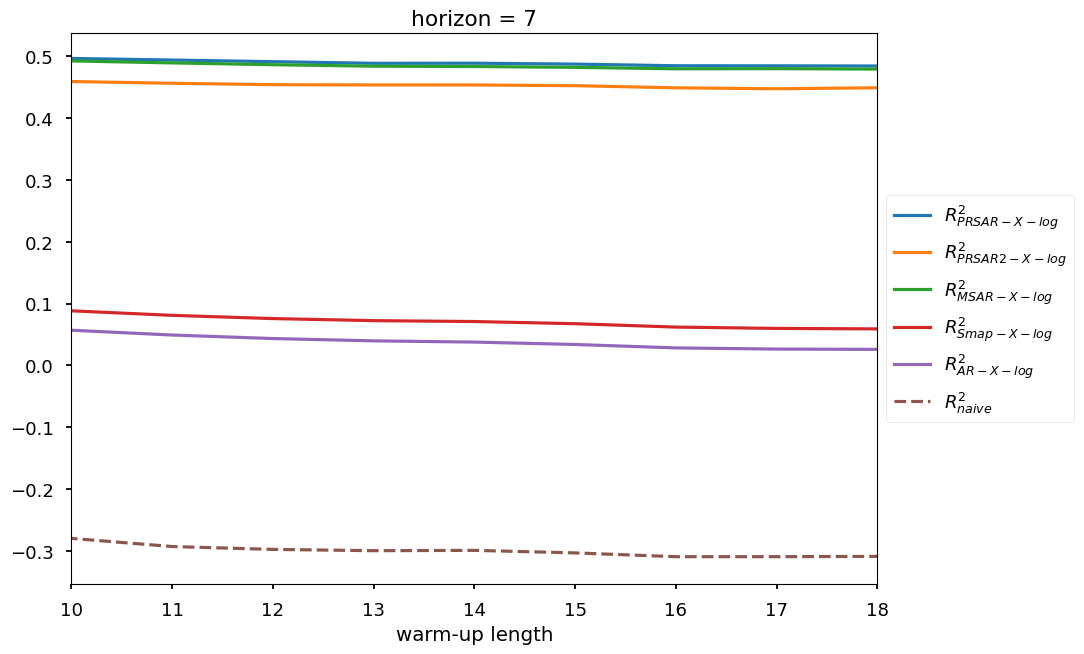

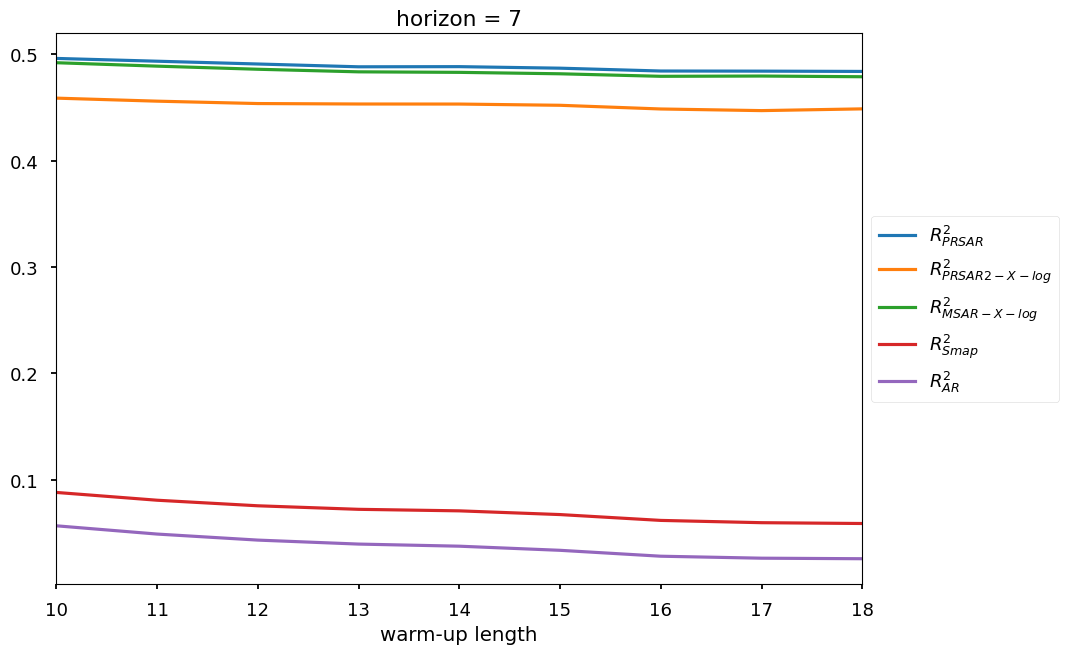

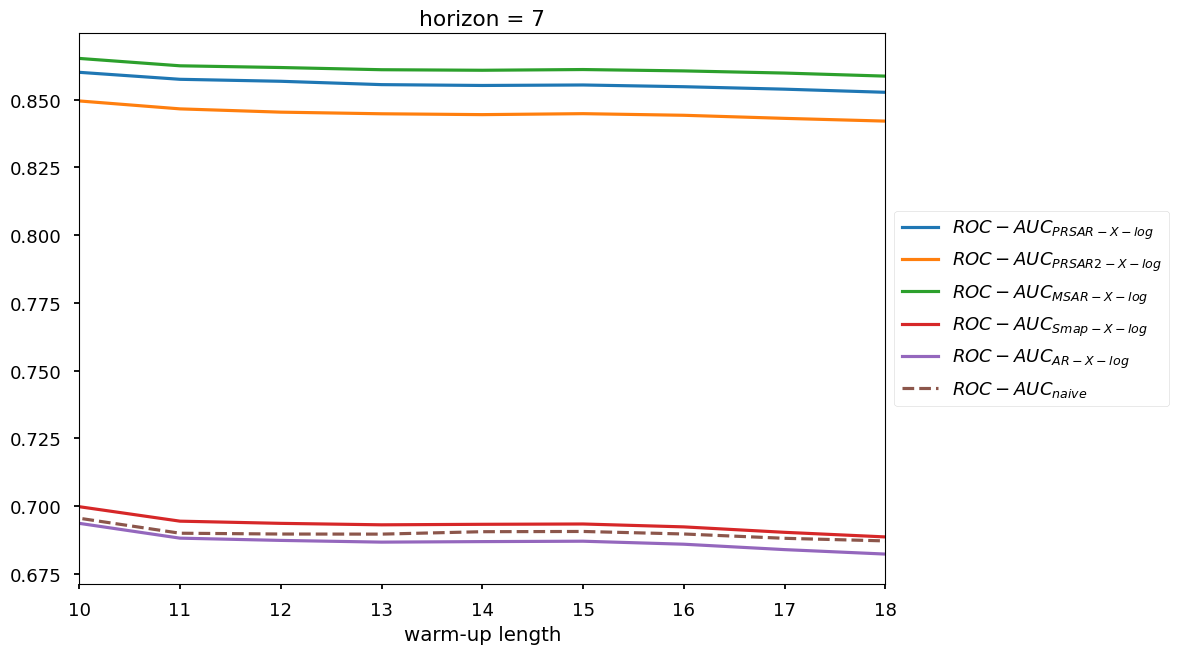

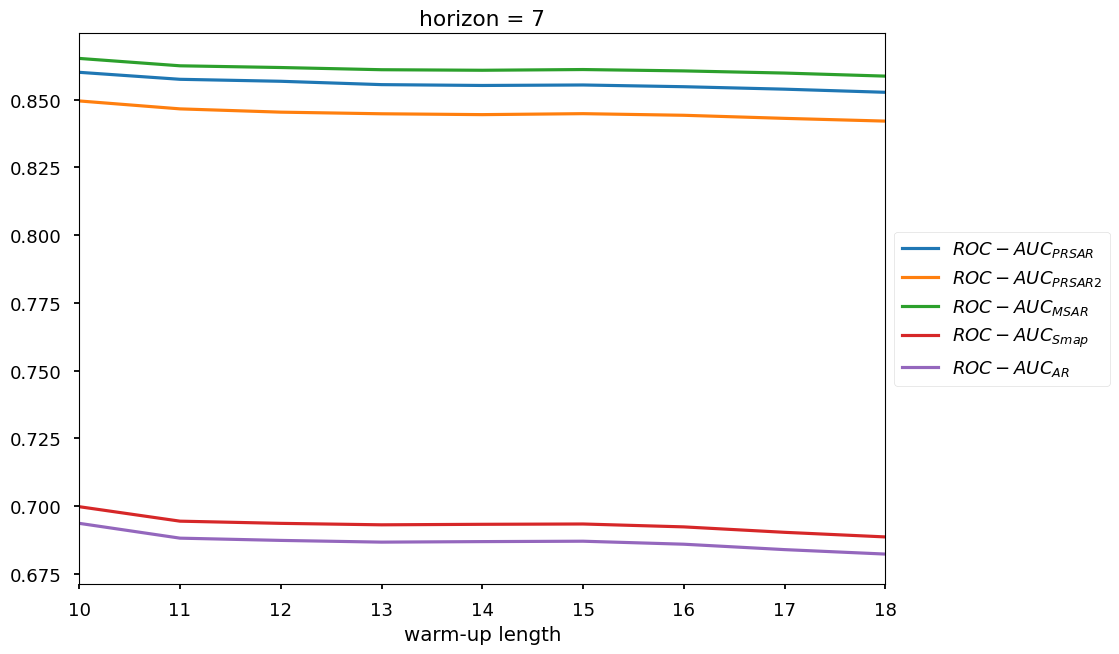

In [17]:

n_seq_warmup = 11
is_phase = True
horizon_forecast = 7

# Data reading
df_pred_eval = df_pred_eval_bak[(df_pred_eval_bak["n_seq_warmup"] == n_seq_warmup) & 
                                (df_pred_eval_bak["is_phase"] == is_phase) &
                                (df_pred_eval_bak["horizon_forecast"] == horizon_forecast)]

list_x, list_r2_naive, list_rocauc_naive = [], [], []
list_r2_ar_log, list_rocauc_ar_log, list_r2_ar, list_rocauc_ar, list_r2_arx_log, list_rocauc_arx_log, list_r2_arx, list_rocauc_arx = [], [], [], [], [], [], [], []
list_r2_smap_log, list_rocauc_smap_log, list_r2_smap, list_rocauc_smap, list_r2_smapx_log, list_rocauc_smapx_log, list_r2_smapx, list_rocauc_smapx = [], [], [], [], [], [], [], []
list_r2_mslr_log, list_rocauc_mslr_log, list_r2_mslr, list_rocauc_mslr, list_r2_mslrx_log, list_rocauc_mslrx_log, list_r2_mslrx, list_rocauc_mslrx = [], [], [], [], [], [], [], []
list_r2_prslr1_log, list_rocauc_prslr1_log, list_r2_prslr1, list_rocauc_prslr1, list_r2_prslr1x_log, list_rocauc_prslr1x_log, list_r2_prslr1x, list_rocauc_prslr1x = [], [], [], [], [], [], [], []
list_r2_prslr2_log, list_rocauc_prslr2_log, list_r2_prslr2, list_rocauc_prslr2, list_r2_prslr2x_log, list_rocauc_prslr2x_log, list_r2_prslr2x, list_rocauc_prslr2x = [], [], [], [], [], [], [], []

for tmp_len_warmup in range(7, 20):
    
    tmp_df_pred_eval = df_pred_eval[df_pred_eval["len_warmup"] == tmp_len_warmup]
    
    tmp_r2_naive, tmp_rocauc_naive = tmp_df_pred_eval["r2_naive"].iloc[0], tmp_df_pred_eval["rocauc_naive"].iloc[0]
    
    tmp_df_pred_eval_ar_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
    tmp_r2_ar_log, tmp_rocauc_ar_log = tmp_df_pred_eval_ar_log["r2_ar"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_ar"].iloc[0]
    tmp_r2_smap_log, tmp_rocauc_smap_log = tmp_df_pred_eval_ar_log["r2_smap"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_smap"].iloc[0]
    tmp_r2_mslr_log, tmp_rocauc_mslr_log = tmp_df_pred_eval_ar_log["r2_mslr"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1_log, tmp_rocauc_prslr1_log = tmp_df_pred_eval_ar_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2_log, tmp_rocauc_prslr2_log = tmp_df_pred_eval_ar_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_ar = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
    tmp_r2_ar, tmp_rocauc_ar = tmp_df_pred_eval_ar["r2_ar"].iloc[0], tmp_df_pred_eval_ar["rocauc_ar"].iloc[0]
    tmp_r2_smap, tmp_rocauc_smap = tmp_df_pred_eval_ar["r2_smap"].iloc[0], tmp_df_pred_eval_ar["rocauc_smap"].iloc[0]
    tmp_r2_mslr, tmp_rocauc_mslr = tmp_df_pred_eval_ar["r2_mslr"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1, tmp_rocauc_prslr1 = tmp_df_pred_eval_ar["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2, tmp_rocauc_prslr2 = tmp_df_pred_eval_ar["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_arx_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
    tmp_r2_arx_log, tmp_rocauc_arx_log = tmp_df_pred_eval_arx_log["r2_ar"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_ar"].iloc[0]
    tmp_r2_smapx_log, tmp_rocauc_smapx_log = tmp_df_pred_eval_arx_log["r2_smap"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_smap"].iloc[0]
    tmp_r2_mslrx_log, tmp_rocauc_mslrx_log = tmp_df_pred_eval_arx_log["r2_mslr"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1x_log, tmp_rocauc_prslr1x_log = tmp_df_pred_eval_arx_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2x_log, tmp_rocauc_prslr2x_log = tmp_df_pred_eval_arx_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_arx = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
    tmp_r2_arx, tmp_rocauc_arx = tmp_df_pred_eval_arx["r2_ar"].iloc[0], tmp_df_pred_eval_arx["rocauc_ar"].iloc[0]
    tmp_r2_smapx, tmp_rocauc_smapx = tmp_df_pred_eval_arx["r2_smap"].iloc[0], tmp_df_pred_eval_arx["rocauc_smap"].iloc[0]
    tmp_r2_mslrx, tmp_rocauc_mslrx = tmp_df_pred_eval_arx["r2_mslr"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1x, tmp_rocauc_prslr1x = tmp_df_pred_eval_arx["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2x, tmp_rocauc_prslr2x = tmp_df_pred_eval_arx["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrxsolu3"].iloc[0]
    
    list_x.append(tmp_len_warmup)
    list_r2_naive.append(tmp_r2_naive)
    list_rocauc_naive.append(tmp_rocauc_naive)
    
    list_r2_ar_log.append(tmp_r2_ar_log)
    list_rocauc_ar_log.append(tmp_rocauc_ar_log)
    list_r2_ar.append(tmp_r2_ar)
    list_rocauc_ar.append(tmp_rocauc_ar)
    list_r2_arx_log.append(tmp_r2_arx_log)
    list_rocauc_arx_log.append(tmp_rocauc_arx_log)
    list_r2_arx.append(tmp_r2_arx)
    list_rocauc_arx.append(tmp_rocauc_arx)
    
    list_r2_smap_log.append(tmp_r2_smap_log)
    list_rocauc_smap_log.append(tmp_rocauc_smap_log)
    list_r2_smap.append(tmp_r2_smap)
    list_rocauc_smap.append(tmp_rocauc_smap)
    list_r2_smapx_log.append(tmp_r2_smapx_log)
    list_rocauc_smapx_log.append(tmp_rocauc_smapx_log)
    list_r2_smapx.append(tmp_r2_smapx)
    list_rocauc_smapx.append(tmp_rocauc_smapx)
    
    list_r2_mslr_log.append(tmp_r2_mslr_log)
    list_rocauc_mslr_log.append(tmp_rocauc_mslr_log)
    list_r2_mslr.append(tmp_r2_mslr)
    list_rocauc_mslr.append(tmp_rocauc_mslr)
    list_r2_mslrx_log.append(tmp_r2_mslrx_log)
    list_rocauc_mslrx_log.append(tmp_rocauc_mslrx_log)
    list_r2_mslrx.append(tmp_r2_mslrx)
    list_rocauc_mslrx.append(tmp_rocauc_mslrx)
    
    list_r2_prslr1_log.append(tmp_r2_prslr1_log)
    list_rocauc_prslr1_log.append(tmp_rocauc_prslr1_log)
    list_r2_prslr1.append(tmp_r2_prslr1)
    list_rocauc_prslr1.append(tmp_rocauc_prslr1)
    list_r2_prslr1x_log.append(tmp_r2_prslr1x_log)
    list_rocauc_prslr1x_log.append(tmp_rocauc_prslr1x_log)
    list_r2_prslr1x.append(tmp_r2_prslr1x)
    list_rocauc_prslr1x.append(tmp_rocauc_prslr1x)
    
    list_r2_prslr2_log.append(tmp_r2_prslr2_log)
    list_rocauc_prslr2_log.append(tmp_rocauc_prslr2_log)
    list_r2_prslr2.append(tmp_r2_prslr2)
    list_rocauc_prslr2.append(tmp_rocauc_prslr2)
    list_r2_prslr2x_log.append(tmp_r2_prslr2x_log)
    list_rocauc_prslr2x_log.append(tmp_rocauc_prslr2x_log)
    list_r2_prslr2x.append(tmp_r2_prslr2x)
    list_rocauc_prslr2x.append(tmp_rocauc_prslr2x)

# R2 plot
# plt.plot(list_x, list_r2_prslr1_log, label = r'$R^2_{PRSAR1-log}$')
# plt.plot(list_x, list_r2_prslr1, label = r'$R^2_{PRSAR1}$')
plt.plot(list_x, list_r2_prslr1x_log, label = r'$R^2_{PRSAR-X-log}$')
# plt.plot(list_x, list_r2_prslr1x, label = r'$R^2_{PRSAR1-X}$')

# plt.plot(list_x, list_r2_prslr2_log, label = r'$R^2_{PRSAR2-log}$')
# plt.plot(list_x, list_r2_prslr2, label = r'$R^2_{PRSAR2}$')
plt.plot(list_x, list_r2_prslr2x_log, label = r'$R^2_{PRSAR2-X-log}$')
# plt.plot(list_x, list_r2_prslr2x, label = r'$R^2_{PRSAR2-X}$')

# plt.plot(list_x, list_r2_mslr_log, label = r'$R^2_{MSAR-log}$')
# plt.plot(list_x, list_r2_mslr, label = r'$R^2_{MSAR}$')
plt.plot(list_x, list_r2_mslrx_log, label = r'$R^2_{MSAR-X-log}$')
# plt.plot(list_x, list_r2_mslrx, label = r'$R^2_{MSAR-X}$')

# plt.plot(list_x, list_r2_smap_log, label = r'$R^2_{Smap-log}$')
# plt.plot(list_x, list_r2_smap, label = r'$R^2_{Smap}$')
plt.plot(list_x, list_r2_smapx_log, label = r'$R^2_{Smap-X-log}$')
# plt.plot(list_x, list_r2_smapx, label = r'$R^2_{Smap-X}$')

# plt.plot(list_x, list_r2_ar_log, label = r'$R^2_{AR-log}$')
# plt.plot(list_x, list_r2_ar, label = r'$R^2_{AR}$')
plt.plot(list_x, list_r2_arx_log, label = r'$R^2_{AR-X-log}$')
# plt.plot(list_x, list_r2_arx, label = r'$R^2_{AR-X}$')

plt.plot(list_x, list_r2_naive, "--", label = r'$R^2_{naive}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# R2 plot
plt.plot(list_x, list_r2_prslr1x_log, label = r'$R^2_{PRSAR}$')
plt.plot(list_x, list_r2_prslr2x_log, label = r'$R^2_{PRSAR2-X-log}$')
plt.plot(list_x, list_r2_mslrx_log, label = r'$R^2_{MSAR-X-log}$')
plt.plot(list_x, list_r2_smapx_log, label = r'$R^2_{Smap}$')
plt.plot(list_x, list_r2_arx_log, label = r'$R^2_{AR}$')
#plt.plot(list_x, list_r2_naive, "--", label = r'$R^2_{naive}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# ROC-AUC plot
# plt.plot(list_x, list_rocauc_prslr1_log, label = r'$ROC-AUC_{PRSAR1-log}$')
# plt.plot(list_x, list_rocauc_prslr1, label = r'$ROC-AUC_{PRSAR1}$')
plt.plot(list_x, list_rocauc_prslr1x_log, label = r'$ROC-AUC_{PRSAR-X-log}$')
# plt.plot(list_x, list_rocauc_prslr1x, label = r'$ROC-AUC_{PRSAR1-X}$')

# plt.plot(list_x, list_rocauc_prslr2_log, label = r'$ROC-AUC_{PRSAR2-log}$')
# plt.plot(list_x, list_rocauc_prslr2, label = r'$ROC-AUC_{PRSAR2}$')
plt.plot(list_x, list_rocauc_prslr2x_log, label = r'$ROC-AUC_{PRSAR2-X-log}$')
# plt.plot(list_x, list_rocauc_prslr2x, label = r'$ROC-AUC_{PRSAR2-X}$')

# plt.plot(list_x, list_rocauc_mslr_log, label = r'$ROC-AUC_{MSAR-log}$')
# plt.plot(list_x, list_rocauc_mslr, label = r'$ROC-AUC_{MSAR}$')
plt.plot(list_x, list_rocauc_mslrx_log, label = r'$ROC-AUC_{MSAR-X-log}$')
# plt.plot(list_x, list_rocauc_mslrx, label = r'$ROC-AUC_{MSAR-X}$')

# plt.plot(list_x, list_rocauc_smap_log, label = r'$ROC-AUC_{Smap-log}$')
# plt.plot(list_x, list_rocauc_smap, label = r'$ROC-AUC_{Smap}$')
plt.plot(list_x, list_rocauc_smapx_log, label = r'$ROC-AUC_{Smap-X-log}$')
# plt.plot(list_x, list_rocauc_smapx, label = r'$ROC-AUC_{Smap-X}$')

# plt.plot(list_x, list_rocauc_ar_log, label = r'$ROC-AUC_{AR-log}$')
# plt.plot(list_x, list_rocauc_ar, label = r'$ROC-AUC_{AR}$')
plt.plot(list_x, list_rocauc_arx_log, label = r'$ROC-AUC_{AR-X-log}$')
# plt.plot(list_x, list_rocauc_arx, label = r'$ROC-AUC_{AR-X}$')

plt.plot(list_x, list_rocauc_naive, "--", label = r'$ROC-AUC_{naive}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# ROC-AUC plot
plt.plot(list_x, list_rocauc_prslr1x_log, label = r'$ROC-AUC_{PRSAR}$')
plt.plot(list_x, list_rocauc_prslr2x_log, label = r'$ROC-AUC_{PRSAR2}$')
plt.plot(list_x, list_rocauc_mslrx_log, label = r'$ROC-AUC_{MSAR}$')
plt.plot(list_x, list_rocauc_smapx_log, label = r'$ROC-AUC_{Smap}$')
plt.plot(list_x, list_rocauc_arx_log, label = r'$ROC-AUC_{AR}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()


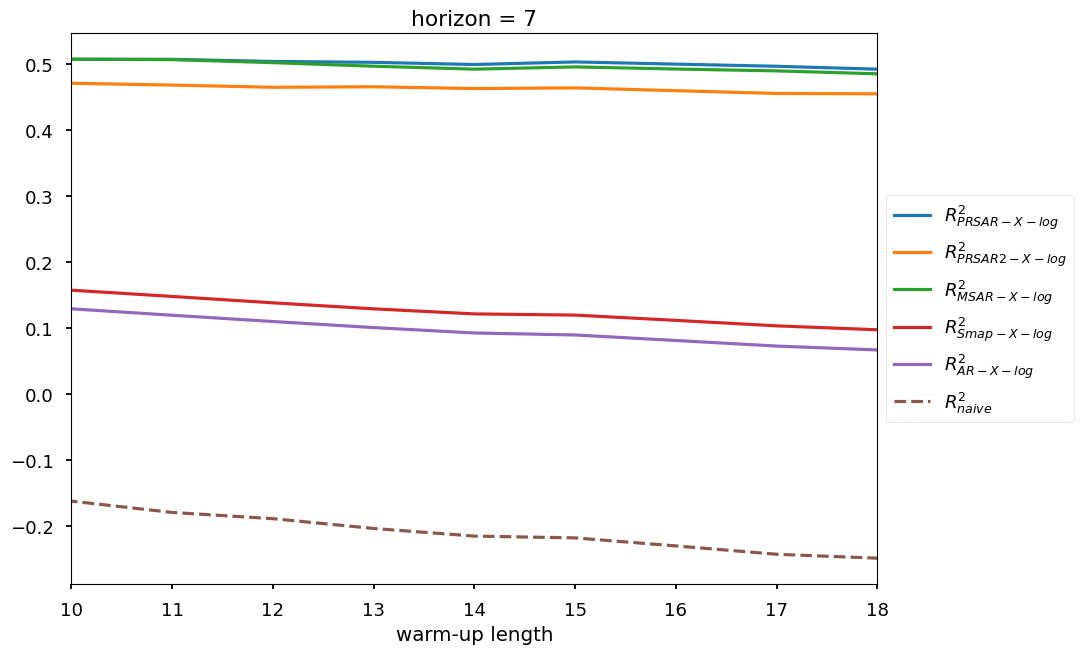

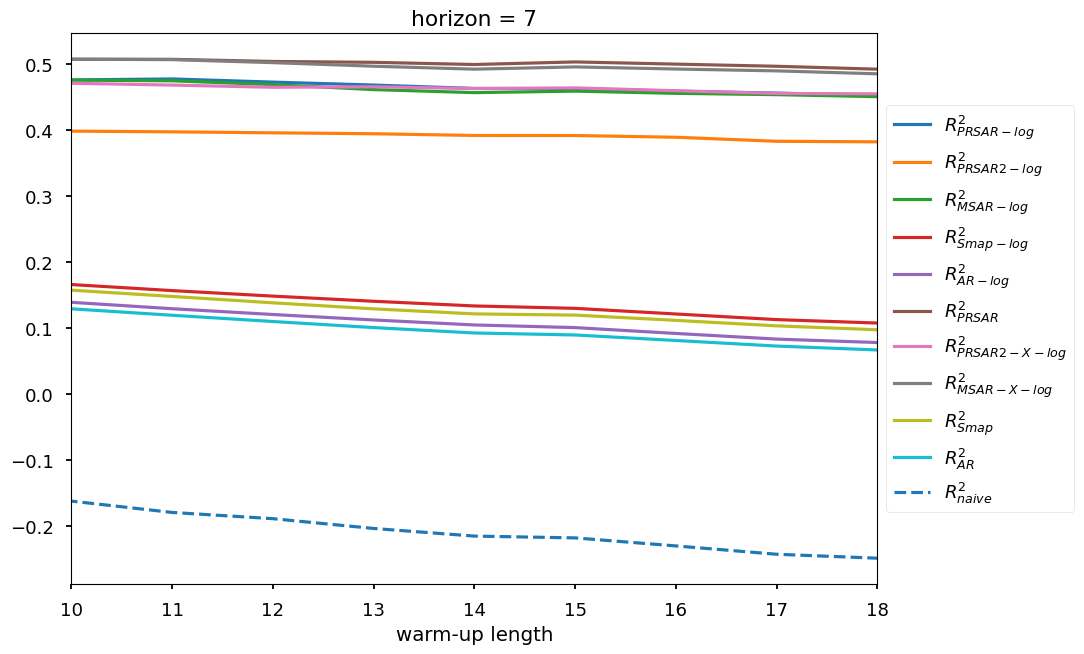

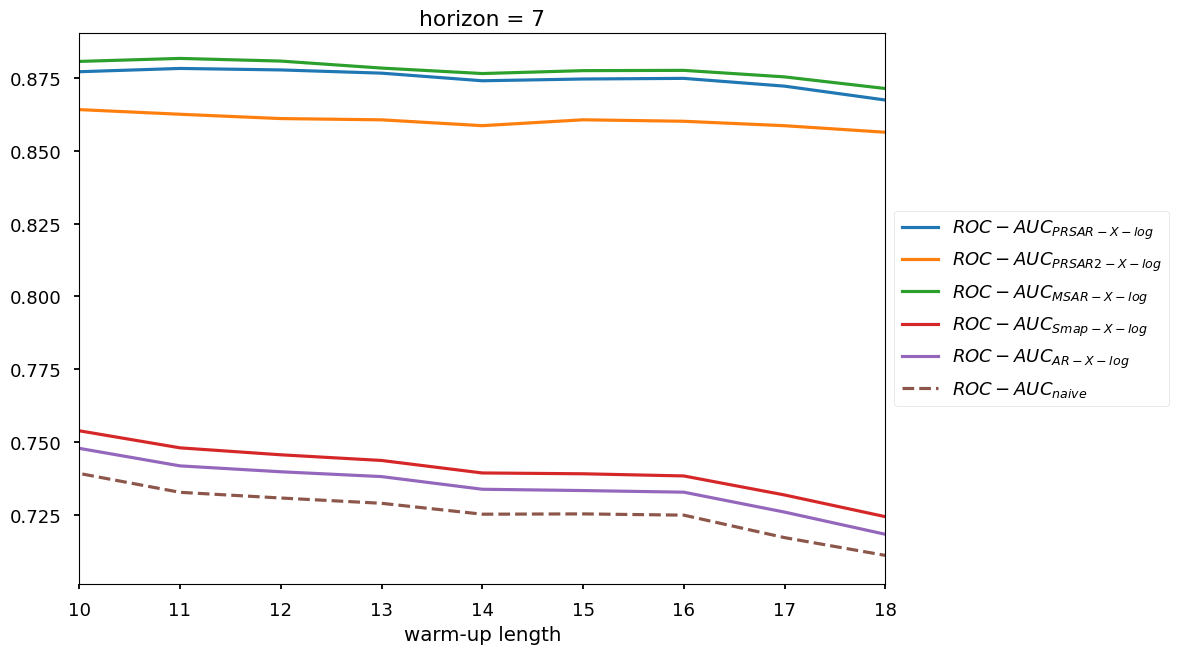

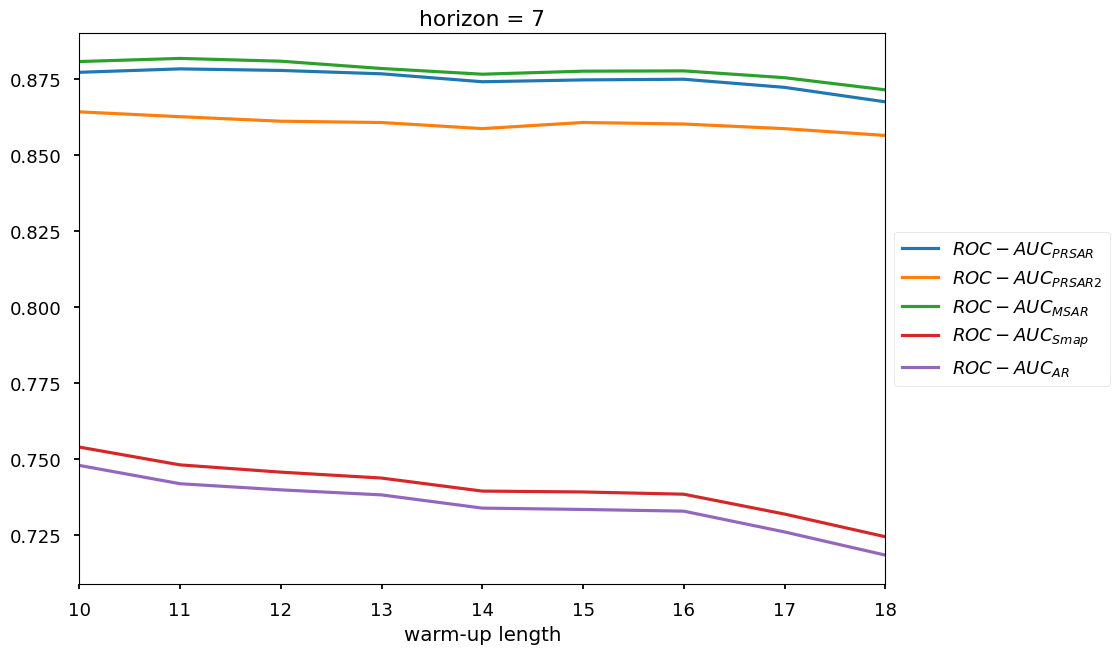

In [18]:

n_seq_warmup = 4
is_phase = True
horizon_forecast = 7

# Data reading
df_pred_eval = df_pred_eval_bak[(df_pred_eval_bak["n_seq_warmup"] == n_seq_warmup) & 
                                (df_pred_eval_bak["is_phase"] == is_phase) &
                                (df_pred_eval_bak["horizon_forecast"] == horizon_forecast)]

list_x, list_r2_naive, list_rocauc_naive = [], [], []
list_r2_ar_log, list_rocauc_ar_log, list_r2_ar, list_rocauc_ar, list_r2_arx_log, list_rocauc_arx_log, list_r2_arx, list_rocauc_arx = [], [], [], [], [], [], [], []
list_r2_smap_log, list_rocauc_smap_log, list_r2_smap, list_rocauc_smap, list_r2_smapx_log, list_rocauc_smapx_log, list_r2_smapx, list_rocauc_smapx = [], [], [], [], [], [], [], []
list_r2_mslr_log, list_rocauc_mslr_log, list_r2_mslr, list_rocauc_mslr, list_r2_mslrx_log, list_rocauc_mslrx_log, list_r2_mslrx, list_rocauc_mslrx = [], [], [], [], [], [], [], []
list_r2_prslr1_log, list_rocauc_prslr1_log, list_r2_prslr1, list_rocauc_prslr1, list_r2_prslr1x_log, list_rocauc_prslr1x_log, list_r2_prslr1x, list_rocauc_prslr1x = [], [], [], [], [], [], [], []
list_r2_prslr2_log, list_rocauc_prslr2_log, list_r2_prslr2, list_rocauc_prslr2, list_r2_prslr2x_log, list_rocauc_prslr2x_log, list_r2_prslr2x, list_rocauc_prslr2x = [], [], [], [], [], [], [], []

list_r2_mslr_svm, list_rocauc_mslr_svm, list_r2_mslrx_svm, list_rocauc_mslrx_svm = [], [], [], []
list_r2_prslr1_svm, list_rocauc_prslr1_svm, list_r2_prslr1x_svm, list_rocauc_prslr1x_svm = [], [], [], []
list_r2_prslr2_svm, list_rocauc_prslr2_svm, list_r2_prslr2x_svm, list_rocauc_prslr2x_svm = [], [], [], []

for tmp_len_warmup in range(7, 20):
    
    tmp_df_pred_eval = df_pred_eval[df_pred_eval["len_warmup"] == tmp_len_warmup]
    
    tmp_r2_naive, tmp_rocauc_naive = tmp_df_pred_eval["r2_naive"].iloc[0], tmp_df_pred_eval["rocauc_naive"].iloc[0]
    
    tmp_df_pred_eval_ar_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
    tmp_r2_ar_log, tmp_rocauc_ar_log = tmp_df_pred_eval_ar_log["r2_ar"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_ar"].iloc[0]
    tmp_r2_smap_log, tmp_rocauc_smap_log = tmp_df_pred_eval_ar_log["r2_smap"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_smap"].iloc[0]
    tmp_r2_mslr_log, tmp_rocauc_mslr_log = tmp_df_pred_eval_ar_log["r2_mslr"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1_log, tmp_rocauc_prslr1_log = tmp_df_pred_eval_ar_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2_log, tmp_rocauc_prslr2_log = tmp_df_pred_eval_ar_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar_log["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_ar = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
    tmp_r2_ar, tmp_rocauc_ar = tmp_df_pred_eval_ar["r2_ar"].iloc[0], tmp_df_pred_eval_ar["rocauc_ar"].iloc[0]
    tmp_r2_smap, tmp_rocauc_smap = tmp_df_pred_eval_ar["r2_smap"].iloc[0], tmp_df_pred_eval_ar["rocauc_smap"].iloc[0]
    tmp_r2_mslr, tmp_rocauc_mslr = tmp_df_pred_eval_ar["r2_mslr"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1, tmp_rocauc_prslr1 = tmp_df_pred_eval_ar["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2, tmp_rocauc_prslr2 = tmp_df_pred_eval_ar["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_arx_log = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == True)]
    tmp_r2_arx_log, tmp_rocauc_arx_log = tmp_df_pred_eval_arx_log["r2_ar"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_ar"].iloc[0]
    tmp_r2_smapx_log, tmp_rocauc_smapx_log = tmp_df_pred_eval_arx_log["r2_smap"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_smap"].iloc[0]
    tmp_r2_mslrx_log, tmp_rocauc_mslrx_log = tmp_df_pred_eval_arx_log["r2_mslr"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1x_log, tmp_rocauc_prslr1x_log = tmp_df_pred_eval_arx_log["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2x_log, tmp_rocauc_prslr2x_log = tmp_df_pred_eval_arx_log["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx_log["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_arx = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearRegression") & (tmp_df_pred_eval["is_log10"] == False)]
    tmp_r2_arx, tmp_rocauc_arx = tmp_df_pred_eval_arx["r2_ar"].iloc[0], tmp_df_pred_eval_arx["rocauc_ar"].iloc[0]
    tmp_r2_smapx, tmp_rocauc_smapx = tmp_df_pred_eval_arx["r2_smap"].iloc[0], tmp_df_pred_eval_arx["rocauc_smap"].iloc[0]
    tmp_r2_mslrx, tmp_rocauc_mslrx = tmp_df_pred_eval_arx["r2_mslr"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1x, tmp_rocauc_prslr1x = tmp_df_pred_eval_arx["r2_mslrx"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2x, tmp_rocauc_prslr2x = tmp_df_pred_eval_arx["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_arx["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_svm = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == False) & (tmp_df_pred_eval["reg_method"] == "LinearSVM") & (tmp_df_pred_eval["is_log10"] == False)]
    tmp_r2_mslr_svm, tmp_rocauc_mslr_svm = tmp_df_pred_eval_ar["r2_mslr"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1_svm, tmp_rocauc_prslr1_svm = tmp_df_pred_eval_ar["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2_svm, tmp_rocauc_prslr2_svm = tmp_df_pred_eval_ar["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrxsolu3"].iloc[0]
    
    tmp_df_pred_eval_svm = tmp_df_pred_eval[(tmp_df_pred_eval["is_cross"] == True) & (tmp_df_pred_eval["reg_method"] == "LinearSVM") & (tmp_df_pred_eval["is_log10"] == False)]
    tmp_r2_mslrx_svm, tmp_rocauc_mslrx_svm = tmp_df_pred_eval_ar["r2_mslr"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslr"].iloc[0]
    tmp_r2_prslr1x_svm, tmp_rocauc_prslr1x_svm = tmp_df_pred_eval_ar["r2_mslrx"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrx"].iloc[0]
    tmp_r2_prslr2x_svm, tmp_rocauc_prslr2x_svm = tmp_df_pred_eval_ar["r2_mslrxsolu3"].iloc[0], tmp_df_pred_eval_ar["rocauc_mslrxsolu3"].iloc[0]
    
    list_x.append(tmp_len_warmup)
    list_r2_naive.append(tmp_r2_naive)
    list_rocauc_naive.append(tmp_rocauc_naive)
    
    list_r2_ar_log.append(tmp_r2_ar_log)
    list_rocauc_ar_log.append(tmp_rocauc_ar_log)
    list_r2_ar.append(tmp_r2_ar)
    list_rocauc_ar.append(tmp_rocauc_ar)
    list_r2_arx_log.append(tmp_r2_arx_log)
    list_rocauc_arx_log.append(tmp_rocauc_arx_log)
    list_r2_arx.append(tmp_r2_arx)
    list_rocauc_arx.append(tmp_rocauc_arx)
    
    list_r2_smap_log.append(tmp_r2_smap_log)
    list_rocauc_smap_log.append(tmp_rocauc_smap_log)
    list_r2_smap.append(tmp_r2_smap)
    list_rocauc_smap.append(tmp_rocauc_smap)
    list_r2_smapx_log.append(tmp_r2_smapx_log)
    list_rocauc_smapx_log.append(tmp_rocauc_smapx_log)
    list_r2_smapx.append(tmp_r2_smapx)
    list_rocauc_smapx.append(tmp_rocauc_smapx)
    
    list_r2_mslr_log.append(tmp_r2_mslr_log)
    list_rocauc_mslr_log.append(tmp_rocauc_mslr_log)
    list_r2_mslr.append(tmp_r2_mslr)
    list_rocauc_mslr.append(tmp_rocauc_mslr)
    list_r2_mslrx_log.append(tmp_r2_mslrx_log)
    list_rocauc_mslrx_log.append(tmp_rocauc_mslrx_log)
    list_r2_mslrx.append(tmp_r2_mslrx)
    list_rocauc_mslrx.append(tmp_rocauc_mslrx)
    
    list_r2_prslr1_log.append(tmp_r2_prslr1_log)
    list_rocauc_prslr1_log.append(tmp_rocauc_prslr1_log)
    list_r2_prslr1.append(tmp_r2_prslr1)
    list_rocauc_prslr1.append(tmp_rocauc_prslr1)
    list_r2_prslr1x_log.append(tmp_r2_prslr1x_log)
    list_rocauc_prslr1x_log.append(tmp_rocauc_prslr1x_log)
    list_r2_prslr1x.append(tmp_r2_prslr1x)
    list_rocauc_prslr1x.append(tmp_rocauc_prslr1x)
    
    list_r2_prslr2_log.append(tmp_r2_prslr2_log)
    list_rocauc_prslr2_log.append(tmp_rocauc_prslr2_log)
    list_r2_prslr2.append(tmp_r2_prslr2)
    list_rocauc_prslr2.append(tmp_rocauc_prslr2)
    list_r2_prslr2x_log.append(tmp_r2_prslr2x_log)
    list_rocauc_prslr2x_log.append(tmp_rocauc_prslr2x_log)
    list_r2_prslr2x.append(tmp_r2_prslr2x)
    list_rocauc_prslr2x.append(tmp_rocauc_prslr2x)
    
    list_r2_mslr_svm.append(tmp_r2_mslr_svm)
    list_rocauc_mslr_svm.append(tmp_rocauc_mslr_svm)
    list_r2_mslrx_svm.append(tmp_r2_mslrx_svm)
    list_rocauc_mslrx_svm.append(tmp_rocauc_mslrx_svm)
    list_r2_prslr1_svm.append(tmp_r2_prslr1_svm)
    list_rocauc_prslr1_svm.append(tmp_rocauc_prslr1_svm)
    list_r2_prslr1x_svm.append(tmp_r2_prslr1x_svm)
    list_rocauc_prslr1x_svm.append(tmp_rocauc_prslr1x_svm)
    list_r2_prslr2_svm.append(tmp_r2_prslr2_svm)
    list_rocauc_prslr2_svm.append(tmp_rocauc_prslr2_svm)
    list_r2_prslr2x_svm.append(tmp_r2_prslr2x_svm)
    list_rocauc_prslr2x_svm.append(tmp_rocauc_prslr2x_svm) 

# R2 plot
# plt.plot(list_x, list_r2_prslr1_log, label = r'$R^2_{PRSAR1-log}$')
# plt.plot(list_x, list_r2_prslr1, label = r'$R^2_{PRSAR1}$')
plt.plot(list_x, list_r2_prslr1x_log, label = r'$R^2_{PRSAR-X-log}$')
# plt.plot(list_x, list_r2_prslr1x, label = r'$R^2_{PRSAR1-X}$')

# plt.plot(list_x, list_r2_prslr2_log, label = r'$R^2_{PRSAR2-log}$')
# plt.plot(list_x, list_r2_prslr2, label = r'$R^2_{PRSAR2}$')
plt.plot(list_x, list_r2_prslr2x_log, label = r'$R^2_{PRSAR2-X-log}$')
# plt.plot(list_x, list_r2_prslr2x, label = r'$R^2_{PRSAR2-X}$')

# plt.plot(list_x, list_r2_mslr_log, label = r'$R^2_{MSAR-log}$')
# plt.plot(list_x, list_r2_mslr, label = r'$R^2_{MSAR}$')
plt.plot(list_x, list_r2_mslrx_log, label = r'$R^2_{MSAR-X-log}$')
# plt.plot(list_x, list_r2_mslrx, label = r'$R^2_{MSAR-X}$')

# plt.plot(list_x, list_r2_smap_log, label = r'$R^2_{Smap-log}$')
# plt.plot(list_x, list_r2_smap, label = r'$R^2_{Smap}$')
plt.plot(list_x, list_r2_smapx_log, label = r'$R^2_{Smap-X-log}$')
# plt.plot(list_x, list_r2_smapx, label = r'$R^2_{Smap-X}$')

# plt.plot(list_x, list_r2_ar_log, label = r'$R^2_{AR-log}$')
# plt.plot(list_x, list_r2_ar, label = r'$R^2_{AR}$')
plt.plot(list_x, list_r2_arx_log, label = r'$R^2_{AR-X-log}$')
# plt.plot(list_x, list_r2_arx, label = r'$R^2_{AR-X}$')

# plt.plot(list_x, list_r2_mslrx_svm, label = r'$R^2_{MSLR-X-SVM}$')
# plt.plot(list_x, list_r2_prslr1x_svm, label = r'$R^2_{PRSAR-X-SVM}$')
# plt.plot(list_x, list_r2_prslr2x_svm, label = r'$R^2_{PRSAR2-X-SVM}$')

plt.plot(list_x, list_r2_naive, "--", label = r'$R^2_{naive}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# R2 plot
plt.plot(list_x, list_r2_prslr1_log, label = r'$R^2_{PRSAR-log}$')
plt.plot(list_x, list_r2_prslr2_log, label = r'$R^2_{PRSAR2-log}$')
plt.plot(list_x, list_r2_mslr_log, label = r'$R^2_{MSAR-log}$')
plt.plot(list_x, list_r2_smap_log, label = r'$R^2_{Smap-log}$')
plt.plot(list_x, list_r2_ar_log, label = r'$R^2_{AR-log}$')
plt.plot(list_x, list_r2_prslr1x_log, label = r'$R^2_{PRSAR}$')
plt.plot(list_x, list_r2_prslr2x_log, label = r'$R^2_{PRSAR2-X-log}$')
plt.plot(list_x, list_r2_mslrx_log, label = r'$R^2_{MSAR-X-log}$')
plt.plot(list_x, list_r2_smapx_log, label = r'$R^2_{Smap}$')
plt.plot(list_x, list_r2_arx_log, label = r'$R^2_{AR}$')
plt.plot(list_x, list_r2_naive, "--", label = r'$R^2_{naive}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# ROC-AUC plot
# plt.plot(list_x, list_rocauc_prslr1_log, label = r'$ROC-AUC_{PRSAR1-log}$')
# plt.plot(list_x, list_rocauc_prslr1, label = r'$ROC-AUC_{PRSAR1}$')
plt.plot(list_x, list_rocauc_prslr1x_log, label = r'$ROC-AUC_{PRSAR-X-log}$')
# plt.plot(list_x, list_rocauc_prslr1x, label = r'$ROC-AUC_{PRSAR1-X}$')

# plt.plot(list_x, list_rocauc_prslr2_log, label = r'$ROC-AUC_{PRSAR2-log}$')
# plt.plot(list_x, list_rocauc_prslr2, label = r'$ROC-AUC_{PRSAR2}$')
plt.plot(list_x, list_rocauc_prslr2x_log, label = r'$ROC-AUC_{PRSAR2-X-log}$')
# plt.plot(list_x, list_rocauc_prslr2x, label = r'$ROC-AUC_{PRSAR2-X}$')

# plt.plot(list_x, list_rocauc_mslr_log, label = r'$ROC-AUC_{MSAR-log}$')
# plt.plot(list_x, list_rocauc_mslr, label = r'$ROC-AUC_{MSAR}$')
plt.plot(list_x, list_rocauc_mslrx_log, label = r'$ROC-AUC_{MSAR-X-log}$')
# plt.plot(list_x, list_rocauc_mslrx, label = r'$ROC-AUC_{MSAR-X}$')

# plt.plot(list_x, list_rocauc_smap_log, label = r'$ROC-AUC_{Smap-log}$')
# plt.plot(list_x, list_rocauc_smap, label = r'$ROC-AUC_{Smap}$')
plt.plot(list_x, list_rocauc_smapx_log, label = r'$ROC-AUC_{Smap-X-log}$')
# plt.plot(list_x, list_rocauc_smapx, label = r'$ROC-AUC_{Smap-X}$')

# plt.plot(list_x, list_rocauc_ar_log, label = r'$ROC-AUC_{AR-log}$')
# plt.plot(list_x, list_rocauc_ar, label = r'$ROC-AUC_{AR}$')
plt.plot(list_x, list_rocauc_arx_log, label = r'$ROC-AUC_{AR-X-log}$')
# plt.plot(list_x, list_rocauc_arx, label = r'$ROC-AUC_{AR-X}$')

plt.plot(list_x, list_rocauc_naive, "--", label = r'$ROC-AUC_{naive}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
#plt.ylim(0, 0.4)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()

# ROC-AUC plot
plt.plot(list_x, list_rocauc_prslr1x_log, label = r'$ROC-AUC_{PRSAR}$')
plt.plot(list_x, list_rocauc_prslr2x_log, label = r'$ROC-AUC_{PRSAR2}$')
plt.plot(list_x, list_rocauc_mslrx_log, label = r'$ROC-AUC_{MSAR}$')
plt.plot(list_x, list_rocauc_smapx_log, label = r'$ROC-AUC_{Smap}$')
plt.plot(list_x, list_rocauc_arx_log, label = r'$ROC-AUC_{AR}$')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(10, 18)
plt.xlabel("warm-up length")
plt.title("horizon = % s" % horizon_forecast)
plt.show()


## End of Notebook